# Single photon analysis for single_photon_experiment_3_atom_loading_advance
Valid for experiments from 2025-02-26 until ...

In this experiment, the raw time tags are saved for both SPCMs. The reference time t1 is saved in reference_tStamps_t1. Atom loading is done by load_MOT_and_FORT_until_atom. Each excitation cycle includes OP, excitation for n_excitation_attempts times (often less than 5), recooling for t_recooling time, repeat the excitation cycle a few times (say 5) before doing atom RO to check for atom. If atom is lost, the excitation cycle stops and atom loading starts. So, n_excitation_cycle is not fixed. All data is assumed to be with_atom. 

To use the analysis code, change the dat in date_filters and find the experiment(s) you want to analyse and write in file_indices. If you like the results and you want to keep them, take a screen clip of the results and save in the powerpoint. All the information you need to know about the experiment should be printed at the end. Please add anything is missing.

In [306]:
date_filters = ["2025-04-02"]

from matplotlib import pyplot as plt
import matplotlib as mpl
from matplotlib.lines import Line2D
import csv
import numpy as np
import os,sys
import PIL # for reading tif images
import h5py
import datetime as dt
import time
from scipy.optimize import curve_fit
from skimage.filters import threshold_otsu
from IPython.display import display, HTML ## for large prints

sys.path.append("..\\")
from h5_data_utilities import * # helper functions for dealing with h5 files

def average_over_measurement(measurements, history):
    iteration = len(history) // measurements
    mean_by_iteration = [np.mean(history[j * measurements:(j + 1) * measurements]) for j in range(iteration)]
    return mean_by_iteration


fnames = get_files_by_criteria(date_filters, # only find files from these date directories
                               name_filters=["GeneralVariableScan"], # only find files containing all these strings
                               condition=lambda filename: True, # use this to filter by experiment parameters, like this: lambda filename: np.bool_(h5py.File(filename)['datasets']['set_current_coil_volts_at_finish'])
                               start_dir=results,
                               include_path=True, # if False, only return the name of the file, not the full path
                               print_filenames=True
)


only_show_i_greater_than = -1

print(f"found {len(fnames)} files")
for i,f in enumerate(fnames):
    if i > only_show_i_greater_than:
        try:
            ds = h5py.File(os.path.join(results, f))['datasets']
            scan_str = str_from_h5(ds['scan_variable1_name'])
            if str_from_h5(ds['scan_variable2_name']) != '':
                scan_str += ", " +str_from_h5(ds['scan_variable2_name'])
            print(f"file {i} ({f}) scanned over "+scan_str)
        except:

            print(f"oops... something wrong with {f}")

found 5 files
file 0 (C:\Networking Experiment\artiq codes\artiq-master\results\2025-04-02\09\000023390-GeneralVariableScan.h5) scanned over dummy_variable
file 1 (C:\Networking Experiment\artiq codes\artiq-master\results\2025-04-02\10\000023391-GeneralVariableScan.h5) scanned over dummy_variable
file 2 (C:\Networking Experiment\artiq codes\artiq-master\results\2025-04-02\10\000023391-GeneralVariableScan_single_photon_experiment_3_atom_load_scan_over_dummy_variable.h5) scanned over dummy_variable
file 3 (C:\Networking Experiment\artiq codes\artiq-master\results\2025-04-02\14\000023392-GeneralVariableScan.h5) scanned over dummy_variable
file 4 (C:\Networking Experiment\artiq codes\artiq-master\results\2025-04-02\14\000023392-GeneralVariableScan_single_photon_experiment_3_atom_load_scan_over_dummy_variable.h5) scanned over dummy_variable


experiment: single_photon_experiment_3_atom_loading_advance
override: {'dummy_variable':4,'t_microwave_pulse':15.0*us}
# of iterations:  1


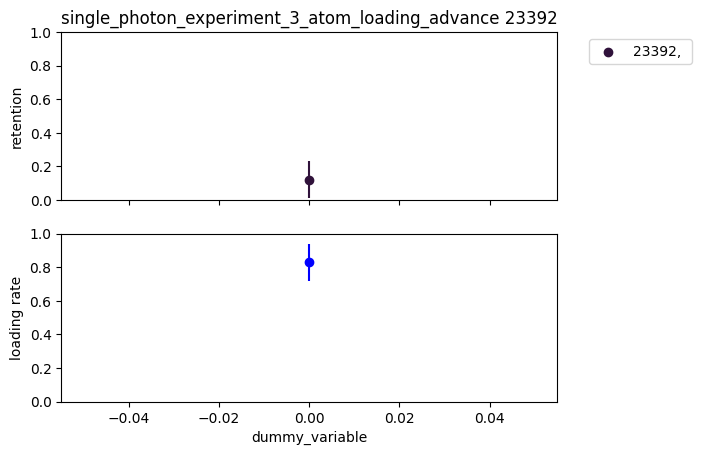

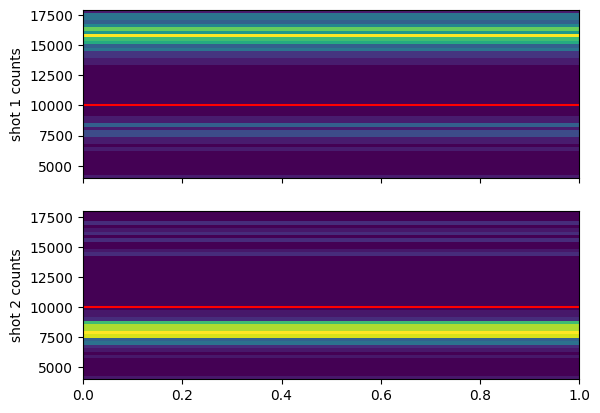

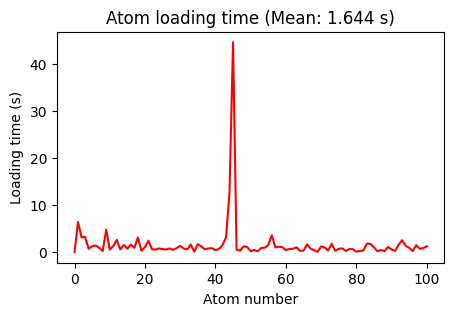

In [307]:
### the file(s) to analyze:
file_indices = {
    3:''
    # 39:'',
} 

compare = True # compare multiple files in the same retention and loading plots
otsu_threshold = False # compute threshold using Otsu method instead doing it by eye. only work when require atom loading = False
showhist = True
showloading = True
custom_xlabel = True
merge_data = False # if True, the datasets will be combined, and if fit=True, the new merged data will be fit. don't try this in 2D
fit = False

showhist_counts = False 

# for plotting
legend_vars =[]   #legend_vars = ['AY_volts_OP', 'f_microwaves_dds'] # will be included in the plot legend
xform_and_label = {}
loc='best'
ret_cmap = mpl.colormaps['turbo']
ldng_cmap = mpl.colormaps['winter']

# for fitting
fit_dict = {}

if compare:
    if showloading:
        fig_ret,axes = plt.subplots(nrows=2, sharex=True)
        ax_ret, ax_ldng = axes
    else:
        fig_ret,ax_ret = plt.subplots()


first_shot_hists = []
second_shot_hists = []
mean1_by_iteration = []
mean2_by_iteration = []

merged_retention = np.array([])
merged_scan_sequence1 = np.array([])
merged_errs = np.array([])
rid_str = ''


for idx,f_item in enumerate(file_indices.items()):
    f_idx,f_comment = f_item   # idx - f_item = {f_idx: f_comment}
    f = h5py.File(os.path.join(results, fnames[f_idx]))
    rid = f['rid'][()]
    h5_archive_and_datasets_to_locals(f, parent_locals=locals(), quiet=True)
    print("experiment:",experiment_function)
    print("override:",override_ExperimentVariables)

    iterations = len(scan_sequence1) #int(len(SPCM0_RO1)/n_measurements)
    print("# of iterations: ", iterations)
    
    if otsu_threshold:
        thresh = threshold_otsu(SPCM0_RO1)
        print("threshold_otsu: ", thresh)
    else:
        cutoff1 = cutoff2 = single_atom_threshold * t_SPCM_first_shot

    
    ### for plotting 
    ### xsteps_xform is a function that can transform scan_sequence1 for plotting. Here it is equal to identity, i.e. no change in scan_sequence1.
    if scan_variable1_name in xform_and_label and custom_xlabel:
        xsteps_xform, xlabel = (xform_and_label[scan_variable1_name]['xsteps_xform'], xform_and_label[scan_variable1_name]['xlabel'])
    else:
        xsteps_xform, xlabel = (lambda x: x, scan_variable1_name)
        

    legend_string = ''
    for a in legend_vars:
        legend_string += f'{a}={locals()[a]}, '
    legend_string = legend_string[:-2]
    f_comment += legend_string

    
    ### get_loading_and_retention
    ### These array have length = iterations
    retention_array, loading_rate_array, n_atoms_loaded_array = get_loading_and_retention(SPCM0_RO1, SPCM0_RO2, n_measurements, iterations, cutoff1, otsu=otsu_threshold)


    ### Necessary to analyze data with 2 scan_sequences
    ### reshaping each array into a 2D array with shape = shape, with order = 'F' (Fortran-style) to sort column by column
    
    ncols = len(scan_sequence2)
    nrows = len(scan_sequence1)
    shape = (len(scan_sequence2),len(scan_sequence1))
    loading_rate_raveled = np.reshape(loading_rate_array,shape,order='F') # rows have constant variable2
    n_atoms_loaded_raveled = np.reshape(n_atoms_loaded_array,shape,order='F') # rows have constant variable2
    retention_raveled = np.reshape(retention_array,shape,order='F') # rows have constant variable2

    
    ### show historam of first_shot and second_shot
    histMin = np.min([SPCM0_RO1, SPCM0_RO2])/t_SPCM_first_shot ## boundary for the histogram plots
    histMax = np.max([SPCM0_RO1, SPCM0_RO2])/t_SPCM_first_shot
    if showhist:
        first_shot_hists.append(
            [np.histogram(SPCM0_RO1[i*n_measurements:(i+1)*n_measurements]/t_SPCM_first_shot,bins=np.linspace(histMin,histMax,50))[0]
                              for i in range(iterations)])

        second_shot_hists.append(
            [np.histogram(SPCM0_RO2[i*n_measurements:(i+1)*n_measurements]/t_SPCM_second_shot,bins=np.linspace(histMin,histMax,50))[0]
                                      for i in range(iterations)])

    
    ### plot a retention curve vs variable 1 for each variable 2 value
    for i, retention, loading, n_loaded, var2 in zip(range(len(scan_sequence2)), retention_raveled, loading_rate_raveled, n_atoms_loaded_raveled, scan_sequence2):
        
        errs = np.array([1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded])
        if not compare:
            if showloading:
                    fig_ret,axes = plt.subplots(nrows=2, sharex=True)
                    ax_ret, ax_ldng = axes
            else:
                fig_ret,ax_ret = plt.subplots()
                
        if not merge_data:
            ax_ret.scatter(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0], label=str(rid)+', '+f_comment, color=ret_cmap(idx/len(file_indices)))
            ax_ret.errorbar(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0], errs[loading > 0], ls='none',color=ret_cmap(idx/len(file_indices)))
            ax_ret.set_ylim((0,1))

            if not ncols > 1 and fit and scan_variable1_name in fit_dict:
                popt, _ = curve_fit(f=fit_dict[scan_variable1_name]['model'], xdata=scan_sequence1, ydata=retention, p0=fit_dict[scan_variable1_name]['p0'], bounds=fit_dict[scan_variable1_name]['bounds'])
                fit_str = "".join([f'{p}={v:.4f}, ' for p,v in zip(fit_dict[scan_variable1_name]['params'], popt)])[:-2]
                print(fit_str)
                hi_res_x = np.linspace(scan_sequence1[0], scan_sequence1[-1], 10*len(scan_sequence1))
                hi_res_x_xform = np.linspace(xsteps_xform(scan_sequence1)[0], xsteps_xform(scan_sequence1)[-1], 10*len(scan_sequence1))
                ax_ret.plot(hi_res_x_xform, fit_dict[scan_variable1_name]['model'](hi_res_x, *popt),linestyle='--',color=ret_cmap(idx/len(file_indices)),label=fit_str)
            else:
                ax_ret.plot(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0],linestyle='--',color=ret_cmap(idx/len(file_indices)))
    
            if not showloading:
                ax_ret.set_xlabel(xlabel)
            ax_ret.set_ylabel("retention")
            #ax_ret.legend(loc=loc)
            ax_ret.legend(bbox_to_anchor=(1.05, 1), loc='upper left')      # This will show the legend outside the plot
            
        else:
            merged_retention = np.concatenate((merged_retention,retention[loading > 0]))
            merged_scan_sequence1 = np.concatenate((merged_scan_sequence1, scan_sequence1[loading > 0]))
            merged_errs = np.concatenate((merged_errs, errs[loading > 0]))
            rid_str += str(rid) + ', '
    
        if showloading:
            ax_ldng.plot(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], linestyle='--',color=ldng_cmap(idx/len(file_indices)))
            ax_ldng.scatter(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], label=rid, color=ldng_cmap(idx/len(file_indices)))
            errs = np.array([1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded])
            ax_ldng.errorbar(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], errs[loading > 0], ls='none', color=ldng_cmap(idx/len(file_indices)))
            ax_ldng.set_ylim((0,1))
            ax_ldng.set_xlabel(xlabel)
            ax_ldng.set_ylabel("loading rate")


if merge_data:
    retention = merged_retention
    scan_sequence1 = merged_scan_sequence1
    errs = merged_errs

    ax_ret.scatter(xsteps_xform(scan_sequence1), retention, color='plum')
    ax_ret.errorbar(xsteps_xform(scan_sequence1), retention, errs, ls='none',color='plum')
    ax_ret.set_ylim((0,1))
    
    if not ncols > 1 and fit and scan_variable1_name in fit_dict:        
        popt, _ = curve_fit(f=fit_dict[scan_variable1_name]['model'], xdata=scan_sequence1, ydata=retention, p0=fit_dict[scan_variable1_name]['p0'], bounds=fit_dict[scan_variable1_name]['bounds'])
        hi_res_x = np.linspace(scan_sequence1[0], scan_sequence1[-1], 10*len(scan_sequence1))
        hi_res_x_xform = np.linspace(xsteps_xform(scan_sequence1)[0], xsteps_xform(scan_sequence1)[-1], 10*len(scan_sequence1))
        fit_str = "".join([f'{p}={v:.4f}, ' for p,v in zip(fit_dict[scan_variable1_name]['params'], popt)])[:-2]
        print(fit_str)
        ax_ret.plot(hi_res_x_xform, fit_dict[scan_variable1_name]['model'](hi_res_x, *popt),linestyle='--',color='violet', label=fit_str)
        ax_ret.legend()
    else:
        ax_ret.plot(xsteps_xform(scan_sequence1), retention,linestyle='--',color='violet')


if not compare or len(file_indices)==1:
    ax_ret.set_title(experiment_function+' '+str(rid))
elif merge_data:
    ax_ret.set_title(experiment_function+' '+ rid_str[:-2])
else:
    ax_ret.set_title(experiment_function)

if showhist:
    fig,axes = plt.subplots(nrows=2,sharex=True)
    ax,ax2 = axes
    cax=ax.imshow(np.array(first_shot_hists[0]).transpose(),origin='lower',extent=[0,iterations,histMin,histMax])
    ax.set_ylabel("shot 1 counts")
    ax.axhline(cutoff1/t_SPCM_first_shot,color='red')
    ax.set_aspect('auto')
    cax2=ax2.imshow(np.array(second_shot_hists[0]).transpose(),origin='lower',extent=[0,iterations,histMin,histMax])
    ax2.set_ylabel("shot 2 counts")
    
    ax2.axhline(cutoff2/t_SPCM_first_shot,color='red')
    ax2.set_aspect('auto')
plt.show()

#######  Atom loading time plot
## We can slice the array to separate iterations later, if we want.
mean_loading_time = np.mean(Atom_loading_time)  
plt.figure(figsize=(5, 3))
plt.plot(Atom_loading_time, 'r-')

plt.xlabel("Atom number")
plt.ylabel("Loading time (s)")
plt.title(f"Atom loading time (Mean: {mean_loading_time:.3f} s)")  
plt.show()

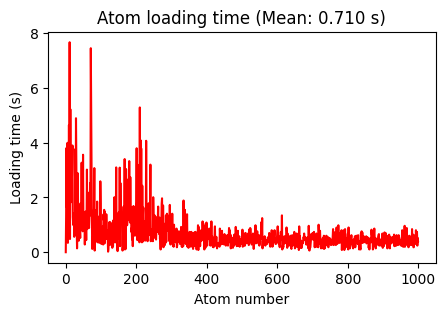

In [165]:
#######  Atom loading time plot
## We can slice the array to separate iterations later, if we want.

data = Atom_loading_time[0:1000]

mean_loading_time = np.mean(data)  
plt.figure(figsize=(5, 3))
plt.plot(data, 'r-')

plt.xlabel("Atom number")
plt.ylabel("Loading time (s)")
plt.title(f"Atom loading time (Mean: {mean_loading_time:.3f} s)") 
plt.show()

n_measurements = 100
excitation pulse width = 30.000000000000004 ns
SPCM window = 200.0 ns
excitation AOM power (dBm) = 2.0
n_excitation_attempts = 5
check atom avery n excitation cycles = 5


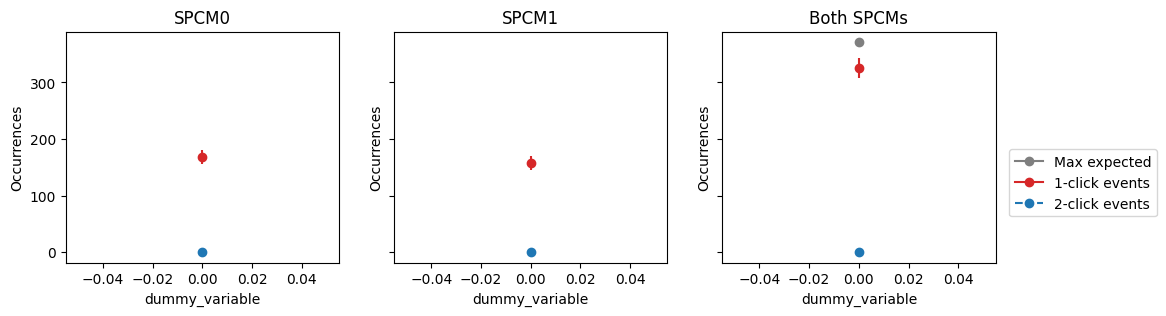

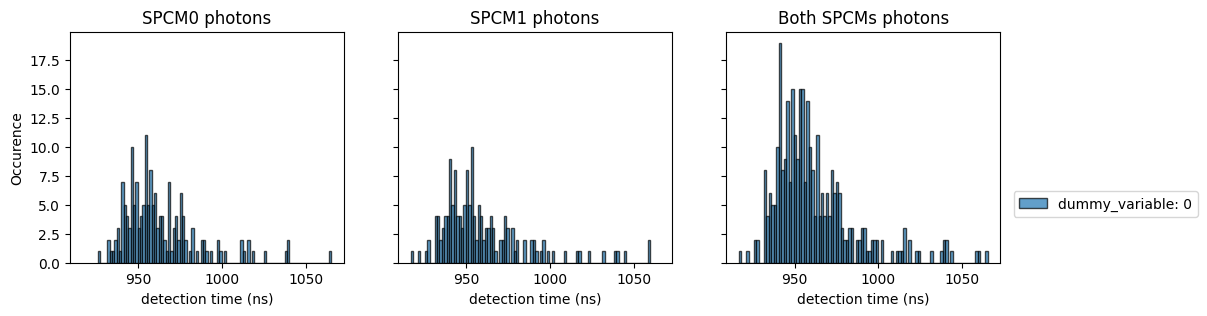

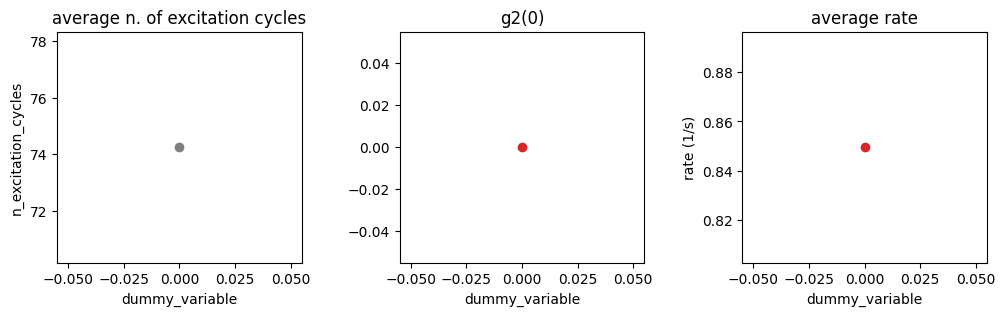

In [308]:
"""
What each variable represents. Example values are mostly from RID 22496, 2025-02-26. Variables ending in _iAll contain data for all interations with length equal to "iterations".

n_measurements = 2000: directly from dataset
iterations = 5: the length of scan_sequence1, directly from dataset
n_excitation_cycles = [0,  2, 20,  8,  2,  8, ...], length = 1 + n_measurements * iterations: the number of excitation cycles in each measurement
n_excitation_cycles_iAll = [16830, 16665, 16488, 16194, 16221], length = iterations: total number of excitation cycles in each iteration as an array.
n_excitation_attempts = 1: directly from dataset. Number of excitation pulses in each excitation cycle.
n_tStamps_iAll = [16830, 16665, 16488, 16194, 16221], length = iterations: total number of timestamps in each iteration as an array. 
SPCM0_SinglePhoton_tStamps = [[0, 0], [-1, -1], [-1, -1], [1.32237714e+06, -1], [-1, -1], ...], length = sum(n_tStamps_iAll) = 82399, for example. Directly from dataset.
SPCM0_tStamps_i =  [[-1, -1], [-1, -1], [1.32237714e+06, -1], [-1, -1], ...], length = elements of n_tStamps_iAll, 16830 for the first iteration, for example. The timestamps in each iteration.
reference_tStamps_t1 = [0, 1322341.65973562, 1322341.65976682, 1322341.65979802, ...], length = sum(n_tStamps_iAll) = 82399, for example. Directly from dataset.
t1_reference_i = [1322341.65973562, 1322341.65976682, 1322341.65979802, ...], length = elements of n_tStamps_iAll, 16830 for the first iteration, for example. The reference times in each iteration.
SPCM0_1click_counts_iAll = [128., 122., 172., 186., 172.], length = iterations: number of 1-click events in each iteration as an array; events in the first column of SPCM0_tStamps_i for different iteration.
SPCM0_2click_counts_iAll = [0., 0., 0., 0., 0.], length = iterations: number of 2-click events in each iteration as an array; events in the second column of SPCM0_tStamps_i for different iteration.
start_indices = [0, 16830, 33495, 49983, 66177], length = iterations: to slice arrays like SPCM0_SinglePhoton_tStamps into iterations. 
    Remember that SPCM0_SinglePhoton_tStamps is a single array with the timestamps for all iterations. 
end_indices = [16830, 33495, 49983, 66177, 82398], length = iterations: same as start_indices
SPCM0_rel_tStamps_i = [1099.89196062, 1088.94892037, 1098.02931547, ...], length = SPCM0_1click_counts_iAll + SPCM0_2click_counts_iAll, for example length is 128 and 122 for first two iterations. 
    This array contains the timestamps relative to the reference time t1 in ns unit. -1 event are excluded and 2-click events are included.
SPCM0_rel_tStamps_iAll = [[1099.89196062, 1088.94892037, 1098.02931547, ...], [..], ..], length = iterations. Arrays of arrays containing all the relative timestamps for all iteration. 
BothSPCMs_tStamps_filtered_i = [[1757511.19383094, 1757533.11171639, ...], length = total number of photons in iteration i, 
    i.e. length = SPCM0_1click_counts_iAll[i] + SPCM1_1click_counts_iAll[i]. Contains all the absolute time stamps from both SPCMs with -1 removed and sorted from small to large.
BothSPCMs_tStamps_filtered_iAll = [[1757511.19383094, 1757533.11171639, ...], [1749316.29104084, 1749328.33163165, ..], ..], length = iterations. Array of arrays keeping all 
    BothSPCMs_tStamps_filtered_i from all iterations.
Ave_photon_rate_iAll = [[0.11084697, 0.1147433 , 0.10952382, 0.1337287 , 0.12123424]], length = iterations. Contains the average photon generation rate for all iterations.

Other notes:
1- Does this work if I change max_clicks from 2 to 1 or 3?

"""

### Print the title of the output
display(HTML(f"""<b style='font-size:18px;'> {date_filters[0]} - RID {rid} - {experiment_function}</b>"""))

Col_Eff = 0.05 # overal expected/theoretical collection and detection efficiency 

### Instead of using a large n_measurements, which can sometimes lead to underflow error, we use dummy_variable to split the measurements. 
### So, if scan_variable1_name == 'dummy_variable', we want to combine all iterations into one:
if scan_variable1_name == 'dummy_variable':
    n_measurements = n_measurements * iterations
    iterations = 1
    scan_sequence1 = [0]

## To look at specific iterations, you can select in scan_sequence_1, for example scan_sequence1 = [0,2]. For now, the first element has to be 0.
# scan_sequence1 = [0,4]
# iterations = len(scan_sequence1)
# n_measurements = n_measurements * iterations


n_excitation_cycles_iAll = np.zeros(iterations, dtype=int) ### total number of excitation cycle in each iteration.
n_tStamps_iAll = np.zeros(iterations, dtype=int)  ### number of timestamps in each iteration. 
for i in range(iterations):
    n_excitation_cycles_iAll[i] = sum(n_excitation_cycles[i*n_measurements+1:(i+1)*n_measurements+1]+1)
    if scan_variable1_name == 'n_excitation_attempts':
        n_excitation_attempts = scan_sequence1[i]
    n_tStamps_iAll[i] = n_excitation_cycles_iAll[i] * n_excitation_attempts
    ### Note that n_excitation_cycles varies in each cycle, each contains n_excitation_attempts.
    ### the first +1 is because the first element in each dataset is 0. 
    ### the last +1 is because there is one more cycle than n_excitation_cycles in each loop. See the oscciloscope. For example, if n_excitation_cycles[j] = 2, 
    ### there are 2+1=3 sets of excitation cycles for that measurement. 
   


SPCM0_1click_counts_iAll = np.array([])
SPCM0_2click_counts_iAll = np.array([])
SPCM1_1click_counts_iAll = np.array([])
SPCM1_2click_counts_iAll = np.array([])

BothSPCMs_tStamps_filtered_iAll = []

SPCM0_rel_tStamps_iAll = []
SPCM1_rel_tStamps_iAll = []

g2_0= np.zeros(iterations)
g2_0_err= np.zeros(iterations)
Ave_photon_rate_iAll = np.zeros(iterations)

### Calculate the ending and starting indices for the iterations
end_indices = np.cumsum(n_tStamps_iAll)
start_indices = np.insert(end_indices[:-1], 0, 0) ### prepend a 0 for the starting index

for i in range(iterations):
    start = start_indices[i]
    end = end_indices[i]
    SPCM0_tStamps_i = SPCM0_SinglePhoton_tStamps[1:][start:end]
    SPCM1_tStamps_i = SPCM1_SinglePhoton_tStamps[1:][start:end]
    t1_reference_i = reference_tStamps_t1[1:][start:end]

    ### number of 1-click events (the first column in SPCM0_tStamps_i is none -1)
    SPCM0_1click_counts_iAll = np.append(SPCM0_1click_counts_iAll, np.count_nonzero(SPCM0_tStamps_i[:, 0] != -1))
    ### number of 2-click events (the 2nd column in SPCM0_tStamps_i is none -1)
    SPCM0_2click_counts_iAll = np.append(SPCM0_2click_counts_iAll, np.count_nonzero(SPCM0_tStamps_i[:, 1] != -1))

    ### number of 1-click events (the first column in SPCM1_tStamps_i is none -1)
    SPCM1_1click_counts_iAll = np.append(SPCM1_1click_counts_iAll, np.count_nonzero(SPCM1_tStamps_i[:, 0] != -1))
    ### number of 2-click events (the 2nd column in SPCM1_tStamps_i is none -1)
    SPCM1_2click_counts_iAll = np.append(SPCM1_2click_counts_iAll, np.count_nonzero(SPCM1_tStamps_i[:, 1] != -1))

    
    ### the timestamps relative to reference time. -1 events are excluded.
    SPCM0_rel_tStamps_i_temp = [row[row != -1] - ref for row, ref in zip(SPCM0_tStamps_i, t1_reference_i)]
    if not SPCM0_rel_tStamps_i_temp: ### np.concatenate crashes on empty lists; if no photon detected, I replace timetags by [0].
        SPCM0_rel_tStamps_i_temp = [[0]]
    SPCM0_rel_tStamps_i_temp2 = np.concatenate(SPCM0_rel_tStamps_i_temp) * 1e9 ## Flatten to combine 1-click and 2-click events.
    SPCM0_rel_tStamps_i = SPCM0_rel_tStamps_i_temp2[SPCM0_rel_tStamps_i_temp2 >= 0] 
    ## in 1 out of 1million case, the reference time is later than the timetag and I get a negative 
    ### SPCM0_rel_tStamps_i element which messes up the histograms. I am simply removing these elements if any, and printing
    if len(SPCM0_rel_tStamps_i) != len(SPCM0_rel_tStamps_i_temp2):
        print(f'Early time stamp for {len(SPCM0_rel_tStamps_i_temp2) - len(SPCM0_rel_tStamps_i)} elements on SPCM0 was detected.')
    SPCM0_rel_tStamps_iAll.append(SPCM0_rel_tStamps_i)  
    
    SPCM1_rel_tStamps_i_temp = [row[row != -1] - ref for row, ref in zip(SPCM1_tStamps_i, t1_reference_i)]
    if not SPCM1_rel_tStamps_i_temp:
        SPCM1_rel_tStamps_i_temp = [[0]]
    SPCM1_rel_tStamps_i_temp2 = np.concatenate(SPCM1_rel_tStamps_i_temp) * 1e9 ## Flatten to combine 1-click and 2-click events.
    SPCM1_rel_tStamps_i = SPCM1_rel_tStamps_i_temp2[SPCM1_rel_tStamps_i_temp2 >= 0] 
    if len(SPCM1_rel_tStamps_i) != len(SPCM1_rel_tStamps_i_temp2):
        print(f'Early time stamp for {len(SPCM1_rel_tStamps_i_temp2) - len(SPCM1_rel_tStamps_i)} elements on SPCM1 was detected.')
    SPCM1_rel_tStamps_iAll.append(SPCM1_rel_tStamps_i)

    
    ### calculate g2 for each iteration. In future, we can also select a narrower coincidence window. Right now the coincidence window is the entire gate window (about 300ns).
    n_coincidence_i = np.sum((SPCM0_tStamps_i[:,0] >= 1) & (SPCM1_tStamps_i[:,0] >= 1)) ### looking at the first clicks for coincidences.
    # n_coincidence_i = 1 ### if there is no coincidence, you can set n_coincidence_i = 1 manually to find the bound to g2 because the next count might be a coincidence.
    if SPCM0_1click_counts_iAll[i] > 0 and SPCM1_1click_counts_iAll[i] > 0:
        g2_0_temp = (n_coincidence_i / 
                  (SPCM0_1click_counts_iAll[i] * SPCM1_1click_counts_iAll[i])) * n_excitation_cycles_iAll[i]
        ### Errors for g2 results are from error propagation assuming Poissonian distribution for counts:
        if n_coincidence_i > 0:
            g2_0_err_temp = g2_0_temp * np.sqrt(1/n_coincidence_i + 1/SPCM0_1click_counts_iAll[i] + 1/SPCM1_1click_counts_iAll[i])
        else:
            g2_0_err_temp = np.nan
    else:
        g2_0_temp = np.nan 
        g2_0_err_temp = np.nan
    g2_0[i] = g2_0_temp
    g2_0_err[i] = g2_0_err_temp

    ############## absolute timestamps of all the photons for rate analysis
    BothSPCMs_tStamps_flatten_i = np.concatenate((SPCM0_tStamps_i, SPCM1_tStamps_i)).flatten() ### flatten to get the timestamps of all photons (1st and 2nd clicks).
    BothSPCMs_tStamps_filtered_i = BothSPCMs_tStamps_flatten_i[BothSPCMs_tStamps_flatten_i != -1]  ### -1 events are removed
    BothSPCMs_tStamps_filtered_i = np.sort(BothSPCMs_tStamps_filtered_i) ### sorted from small to large timestamps
    BothSPCMs_tStamps_filtered_iAll.append(BothSPCMs_tStamps_filtered_i)


print(f'n_measurements = {n_measurements}')
print(f'excitation pulse width = {t_excitation_pulse/10**-9}','ns')
print(f'SPCM window = {t_photon_collection_time/10**-9}', 'ns')
print(f'excitation AOM power (dBm) = {p_excitation}')
print(f'n_excitation_attempts = {n_excitation_attempts}')
print(f'check atom avery n excitation cycles = {atom_check_every_n}')


BothSPCMs_1click_counts_iAll = SPCM0_1click_counts_iAll + SPCM1_1click_counts_iAll
BothSPCMs_2click_counts_iAll = SPCM0_2click_counts_iAll + SPCM1_2click_counts_iAll

#############  Average photon generation rate calculated from last timestamp minus first timestamp.
for i in range(iterations):
    Ave_photon_rate_iAll[i] = (BothSPCMs_1click_counts_iAll[i] + BothSPCMs_2click_counts_iAll[i]) / (max(BothSPCMs_tStamps_filtered_iAll[i])-min(BothSPCMs_tStamps_filtered_iAll[i]))
    

###################################################### plot of 1-click and 2-click counts
fig, axs = plt.subplots(1, 3, figsize=(12, 3), sharey=True)

### SPCM0
axs[0].plot(scan_sequence1, SPCM0_1click_counts_iAll, label='1-click events', ls='solid', color='tab:red', marker='o')
axs[0].plot(scan_sequence1, SPCM0_2click_counts_iAll, label='2-click events', ls='dashed', color='tab:blue', marker='o')
axs[0].errorbar(scan_sequence1, SPCM0_1click_counts_iAll, yerr=np.sqrt(SPCM0_1click_counts_iAll), ls='none', color='tab:red')
axs[0].errorbar(scan_sequence1, SPCM0_2click_counts_iAll, yerr=np.sqrt(SPCM0_2click_counts_iAll), ls='none', color='tab:blue')
axs[0].set_title('SPCM0')
axs[0].set_ylabel('Occurrences')
axs[0].set_xlabel(scan_variable1_name);

### SPCM1
axs[1].plot(scan_sequence1, SPCM1_1click_counts_iAll, label='1-click events', ls='solid', color='tab:red', marker='o')
axs[1].plot(scan_sequence1, SPCM1_2click_counts_iAll, label='2-click events', ls='dashed', color='tab:blue', marker='o')
axs[1].errorbar(scan_sequence1, SPCM1_1click_counts_iAll, yerr=np.sqrt(SPCM1_1click_counts_iAll), ls='none', color='tab:red')
axs[1].errorbar(scan_sequence1, SPCM1_2click_counts_iAll, yerr=np.sqrt(SPCM1_2click_counts_iAll), ls='none', color='tab:blue')
axs[1].set_title('SPCM1')
axs[1].set_ylabel('Occurrences')
axs[1].set_xlabel(scan_variable1_name);

### both SPCMs
axs[2].plot(scan_sequence1, n_excitation_cycles_iAll * Col_Eff, label='Max expected', ls='solid', color='tab:gray', marker='o') ### I assumed only one excitation can happen with n_excitation_attempts
axs[2].plot(scan_sequence1, BothSPCMs_1click_counts_iAll, label='1-click events', ls='solid', color='tab:red', marker='o')
axs[2].plot(scan_sequence1, BothSPCMs_2click_counts_iAll, label='2-click events', ls='dashed', color='tab:blue', marker='o')
axs[2].errorbar(scan_sequence1, BothSPCMs_1click_counts_iAll, yerr=np.sqrt(BothSPCMs_1click_counts_iAll), ls='none', color='tab:red')
axs[2].errorbar(scan_sequence1, BothSPCMs_2click_counts_iAll, yerr=np.sqrt(BothSPCMs_2click_counts_iAll), ls='none', color='tab:blue')
axs[2].set_title('Both SPCMs')
axs[2].set_ylabel('Occurrences')
axs[2].set_xlabel(scan_variable1_name);
axs[2].legend(loc=(1.05,0.2))
##########################################################################################


BothSPCMs_rel_tStamps_iAll = [np.concatenate((spcm0, spcm1)) for spcm0, spcm1 in zip(SPCM0_rel_tStamps_iAll, SPCM1_rel_tStamps_iAll)]

###################################################### plot of photon histograms
for i in range(iterations):
    fig, axs = plt.subplots(1, 3, figsize=(12, 3), sharey=True, sharex=True)
    
    axs[0].hist(SPCM0_rel_tStamps_iAll[i], bins=100, edgecolor='black', alpha=0.7)
    axs[0].set_xlabel("detection time (ns)")
    axs[0].set_ylabel("Occurence")
    axs[0].set_title("SPCM0 photons")
    
    axs[1].hist(SPCM1_rel_tStamps_iAll[i], bins=100, edgecolor='black', alpha=0.7)
    axs[1].set_xlabel("detection time (ns)")
    axs[1].set_title("SPCM1 photons");

    axs[2].hist(BothSPCMs_rel_tStamps_iAll[i], bins=100, edgecolor='black', alpha=0.7, label=f'{scan_variable1_name}: {scan_sequence1[i]}')
    axs[2].set_xlabel("detection time (ns)")
    axs[2].set_title("Both SPCMs photons")
    axs[2].legend(loc=(1.05, 0.2))
##########################################################################################


fig, axs = plt.subplots(1, 3, figsize=(12, 3))
########################################## Plot average number of excitation_cycles per measuremnt
axs[0].plot(scan_sequence1, n_excitation_cycles_iAll/n_measurements, label='ave excitation cycle', marker='o', color='tab:gray')
axs[0].set_xlabel(scan_variable1_name)
axs[0].set_ylabel('n_excitation_cycles')
axs[0].set_title('average n. of excitation cycles')

########################################## Plot g2
axs[1].plot(scan_sequence1, g2_0, marker='o', color='tab:red')
axs[1].errorbar(scan_sequence1, g2_0, yerr=g2_0_err, ls='none',color='tab:red')
axs[1].set_xlabel(scan_variable1_name)
# axs[1].set_ylabel('g2(0)')
axs[1].set_title('g2(0)');

########################################## Plot avergae rate
axs[2].plot(scan_sequence1, Ave_photon_rate_iAll, marker='o', color='tab:red')
# axs[2].legend(loc=(1.05,0.5))
axs[2].set_xlabel(scan_variable1_name)
axs[2].set_ylabel('rate (1/s)')
axs[2].set_title('average rate');

plt.subplots_adjust(wspace=0.4)  # Increase spacing between subplots
plt.show()



## Miscellaneous calculations

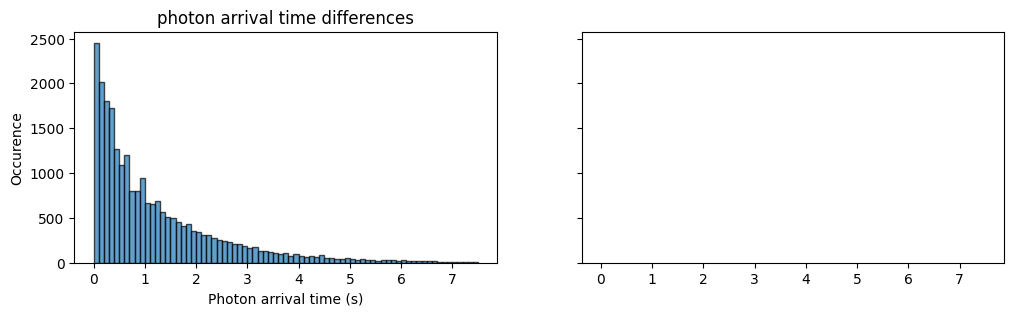

In [227]:
"""
Detailed rate analysis.

"""
########################################## Plot histogram of photon arrival times

for i in range(iterations):
    fig, axs = plt.subplots(1, 2, figsize=(12, 3), sharey=True, sharex=True)
    time_diffs = np.diff(BothSPCMs_tStamps_filtered_iAll[i])
    data_temp = np.sort(time_diffs) ### sorted so we can easily select and zoom into short times, for example.
    data = data_temp[0:-100] ### In case the last few times are too long, remove them from the data.

    bin_width = 0.1  ### in seconds
    Bins = np.arange(data.min(), data.max() + bin_width, bin_width)
    
    axs[0].hist(data, bins=Bins, edgecolor='black', alpha=0.7, log=False) ### log=True applies log-scale to y-axis
    axs[0].set_xlabel("Photon arrival time (s)")
    axs[0].set_ylabel("Occurence")
    axs[0].set_title("photon arrival time differences")
    
    # axs[1].hist(SPCM1_rel_tStamps_iAll[i], bins=100, edgecolor='black', alpha=0.7)
    # axs[1].set_xlabel("detection time (ns)")
    # axs[1].set_title("SPCM1 photons");

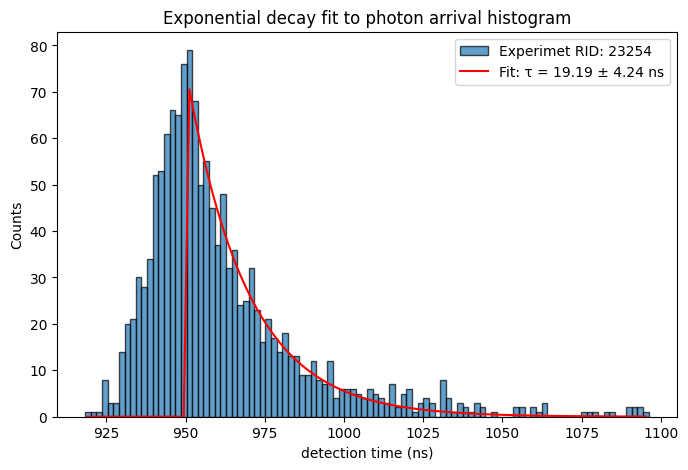

In [259]:
"""   Fitting exponential decay to the histogram  """

data = BothSPCMs_rel_tStamps_iAll[0]
### Create histogram and get bin edges & counts
bin_counts, bin_edges = np.histogram(data, bins=100)  

### Compute bin centers from edges
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

### exponential decay function for fit
def exp_decay(t, t0, N0, tau):
    return N0 * np.exp(-(t - t0) / tau) * (t > t0)  # Step function ensures decay starts at t0

### Initial guesses for fitting parameters
t0_guess = 955  # Estimate for the start of decay
N0_guess = max(bin_counts) 
tau_guess = 23  # Expected atomic lifetime in ns

### Fit the histogram data to the exponential function
params, covariance = curve_fit(exp_decay, bin_centers, bin_counts, p0=[t0_guess, N0_guess, tau_guess])

### Extract fitted parameters and uncertainties
t0_fit, N0_fit, tau_fit = params
t0_err, N0_err, tau_err = np.sqrt(np.diag(covariance))  # Standard errors

### Generate curve using fitted parameters
fit_curve = exp_decay(bin_centers, t0_fit, N0_fit, tau_fit)


plt.figure(figsize=(8, 5))
plt.hist(data, bins=100, edgecolor='black', alpha=0.7, label=f"Experimet RID: {rid}")
plt.plot(bin_centers, fit_curve, 'r-', label=f"Fit: τ = {tau_fit:.2f} ± {tau_err:.2f} ns")

plt.xlabel("detection time (ns)")
plt.ylabel("Counts")
plt.title("Exponential decay fit to photon arrival histogram")
plt.legend()
plt.show()


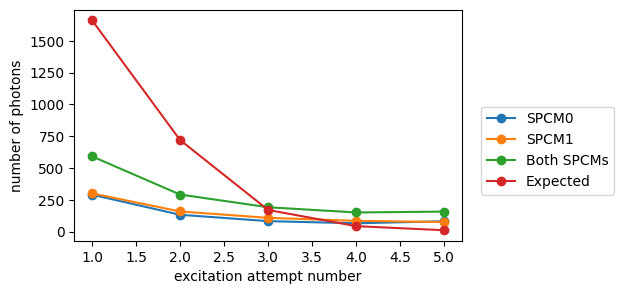

In [260]:
"""
If n_excitation_attempt is 3, for example, do we detect more photons from the first attempt? This analysis looks at the number of photons we get from each attempt. 

"""

SPCM0_counts_in_each_attempt = []
SPCM1_counts_in_each_attempt = []

for j in range(n_excitation_attempts):
    ### Each group is the timestamps for separate excitation attempts. If n_excitation-attempts = 3, for example, we have 3 groups.
    SPCM0_group_j = SPCM0_tStamps_i[j::n_excitation_attempts, 0]  ### Extract first element (first click) from each subarray
    SPCM0_counts_in_attempt_j = np.count_nonzero(SPCM0_group_j != -1)
    SPCM0_counts_in_each_attempt.append(SPCM0_counts_in_attempt_j)

    SPCM1_group_j = SPCM1_tStamps_i[j::n_excitation_attempts, 0]  ### Extract first element (first click) from each subarray
    SPCM1_counts_in_attempt_j = np.count_nonzero(SPCM1_group_j != -1)
    SPCM1_counts_in_each_attempt.append(SPCM1_counts_in_attempt_j)

Both_SPCMs_in_each_attempt = np.array(SPCM0_counts_in_each_attempt) + np.array(SPCM1_counts_in_each_attempt)


######################################## Theoretical expectation
"""
The probability of excitation and detection as a function of excitation attempt. 

2/3 is the probability of decay to mF=-1 and +1. 
See the report on wiki early in early March 2025 for details. 

"""
Pe = 0.85  ### Probability of excitation with the excitation pulse
eta = 0.05 ### overal detection efficiency
P0 = 0.80 ### optical pumping fidelity
n_max = 5  # Number of elements

n_try = n_excitation_cycles_iAll[0] ### the number of excitation cycles in the entire experiemnt.

attempt_values = np.arange(1, n_max + 1)  # n from 1 to n_max
Expected_photons_array = [n_try * eta * P0 * Pe * 2 / 3]  # First element

# Compute remaining elements iteratively
for n in range(2, n_max+1):
    Expected_photons_array.append(n_try * eta * P0 * Pe * 2 / 3 * ((Pe / 3) ** (n-1) + (1 - Pe) ** (n-1)))
############################################################

plt.figure(figsize=(5,3))
plt.plot(range(1, n_excitation_attempts + 1), SPCM0_counts_in_each_attempt, marker='o', linestyle='-',label = "SPCM0")
plt.plot(range(1, n_excitation_attempts + 1), SPCM1_counts_in_each_attempt, marker='o', linestyle='-',label = "SPCM1")
plt.plot(range(1, n_excitation_attempts + 1), Both_SPCMs_in_each_attempt, marker='o', linestyle='-',label = "Both SPCMs")
plt.plot(attempt_values, Expected_photons_array, marker='o', linestyle='-', label = "Expected")
plt.xlabel("excitation attempt number")
plt.ylabel("number of photons")
plt.legend(loc=(1.05,0.2))
plt.show()

In [261]:
""" In each excitation cycle we excite the atom n_excitation_attempts times. But we expect one photon from all these attempts in each cycle. This section finds
the number of timestamps occuring within a short window that covers all the excitation attempts. 

"""
time_window = 1e-3

for i in range(iterations):
    data = BothSPCMs_tStamps_filtered_iAll[i]
    
    # Compute time differences between consecutive timestamps
    time_diffs = np.diff(data)
    
    # Create a histogram: Count the number of time differences ≤ time_window
    num_events_in_window = np.sum(time_diffs <= time_window)
    
    print(f"Total events within {time_window} units: {num_events_in_window}")


Total events within 0.001 units: 13


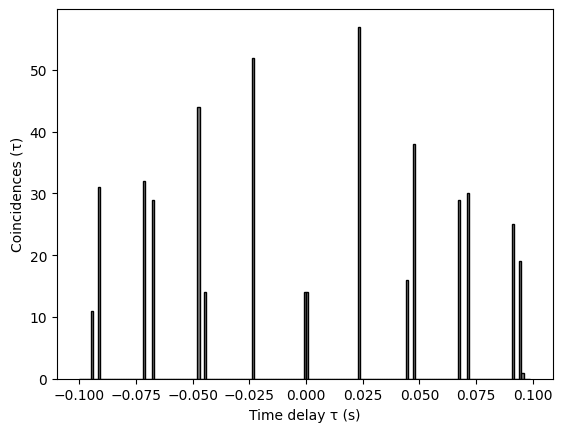

In [172]:
"""
g2 correlation measurement. I need to think more about the following: the photons are not expected at a fixed frequency. There is about 5-15ms recooling for a few times, 
after which we have 20ms RO, there are sometimes a few excitation attempts, etc. Do these periods affect the g2 correlation graph? I can also simulate the data. 

"""

### removing the elements with no photons and flatten the array:
SPCM0_tStamps_i_filtered = SPCM0_tStamps_i[SPCM0_tStamps_i != -1].flatten()
SPCM1_tStamps_i_filtered = SPCM1_tStamps_i[SPCM1_tStamps_i != -1].flatten()

def compute_g2(spcm0_times, spcm1_times, bin_width=1e-3, max_tau=100e-3):
    taus = np.arange(-max_tau, max_tau, bin_width)  # Time bins
    counts, _ = np.histogram(spcm1_times[:, None] - spcm0_times, bins=taus)

    ### Normalization (optional, assuming constant background)
    # norm_factor = (len(spcm0_times) * len(spcm1_times)) / (2 * max_tau / bin_width)
    # g2 = counts / norm_factor
    g2 = counts

    return taus[:-1] + bin_width / 2, g2, bin_width  # Return bin width for bar plot

taus, g2_values, bin_width = compute_g2(SPCM0_tStamps_i_filtered, SPCM1_tStamps_i_filtered)

plt.bar(taus, g2_values, width=1*bin_width, align='center', color='grey', edgecolor='k')
plt.xlabel("Time delay τ (s)")
plt.ylabel("Coincidences (τ)")
plt.show()

# Single photon analysis - load_MOT_and_FORT_until_atom (contains g2 but not finished)
Delete this after adding excitation attempt to the cycle and after you got good data again.
This is anaylysis for the new atom loading sequence that turns on the MOT and FORT until an atom is trapped. The raw time tags are saved for both SPCMs. SPCM0 has one more column for the time t1 marking the excitation time for reference.

The impportant difference for this analysis is that n_excitation_cycle is not fixed anymore. We exit the excitation cycle when the atom is lost. So, atom retained fraction is meaningless. valid for experiments from 2025-02-15 until 2025-02-19.

Analysis for our first search for photons emitted following an excitation pulse, with $g^{(2)}(0)$ calculations. 

To use the analysis code, change the dat in date_filters and find the experiment(s) you want to analyse and write in file_indices. If you like the results and you want to keep them, take a screen clip of the results and save in the powerpoint. All the information you need to know about the experiment should be printed at the end. Please add anything is missing.

In [5]:
date_filters = ["2025-02-15"]

from matplotlib import pyplot as plt
import matplotlib as mpl
from matplotlib.lines import Line2D
import csv
import numpy as np
import os,sys
import PIL # for reading tif images
import h5py
import datetime as dt
import time
from scipy.optimize import curve_fit
from skimage.filters import threshold_otsu
from IPython.display import display, HTML ## for large prints

sys.path.append("..\\")
from h5_data_utilities import * # helper functions for dealing with h5 files

def average_over_measurement(measurements, history):
    iteration = len(history) // measurements
    mean_by_iteration = [np.mean(history[j * measurements:(j + 1) * measurements]) for j in range(iteration)]
    return mean_by_iteration


fnames = get_files_by_criteria(date_filters, # only find files from these date directories
                               name_filters=["GeneralVariableScan"], # only find files containing all these strings
                               condition=lambda filename: True, # use this to filter by experiment parameters, like this: lambda filename: np.bool_(h5py.File(filename)['datasets']['set_current_coil_volts_at_finish'])
                               start_dir=results,
                               include_path=True, # if False, only return the name of the file, not the full path
                               print_filenames=True
)


only_show_i_greater_than = -1

print(f"found {len(fnames)} files")
for i,f in enumerate(fnames):
    if i > only_show_i_greater_than:
        try:
            ds = h5py.File(os.path.join(results, f))['datasets']
            scan_str = str_from_h5(ds['scan_variable1_name'])
            if str_from_h5(ds['scan_variable2_name']) != '':
                scan_str += ", " +str_from_h5(ds['scan_variable2_name'])
            print(f"file {i} ({f}) scanned over "+scan_str)
        except:

            print(f"oops... something wrong with {f}")

skipping C:\Networking Experiment\artiq codes\artiq-master\results\2025-02-15\22\000022260-GeneralVariableScan.h5, which is corrupt
found 12 files
file 0 (C:\Networking Experiment\artiq codes\artiq-master\results\2025-02-15\21\000022254-GeneralVariableScan.h5) scanned over dummy_variable
file 1 (C:\Networking Experiment\artiq codes\artiq-master\results\2025-02-15\21\000022255-GeneralVariableScan.h5) scanned over dummy_variable
file 2 (C:\Networking Experiment\artiq codes\artiq-master\results\2025-02-15\21\000022255-GeneralVariableScan_single_photon_experiment_2_atom_load_scan_over_dummy_variable.h5) scanned over dummy_variable
file 3 (C:\Networking Experiment\artiq codes\artiq-master\results\2025-02-15\21\000022256-GeneralVariableScan.h5) scanned over dummy_variable
file 4 (C:\Networking Experiment\artiq codes\artiq-master\results\2025-02-15\21\000022256-GeneralVariableScan_single_photon_experiment_2_atom_load_scan_over_dummy_variable.h5) scanned over dummy_variable
file 5 (C:\Networki

experiment: single_photon_experiment_2_atom_loading_advance
override: {'dummy_variable':4}
# of iterations:  5


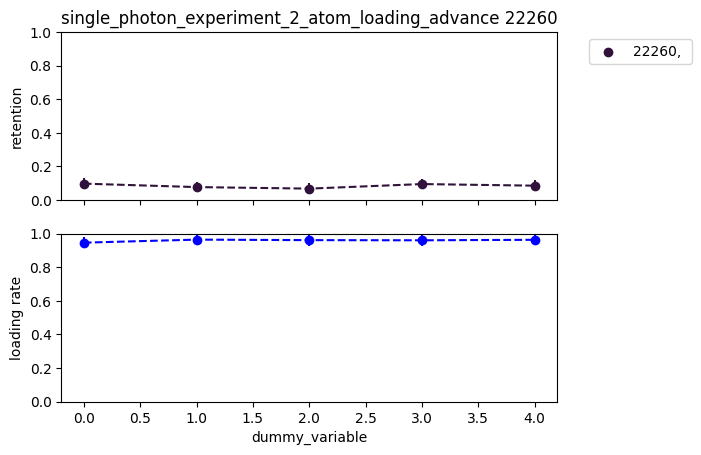

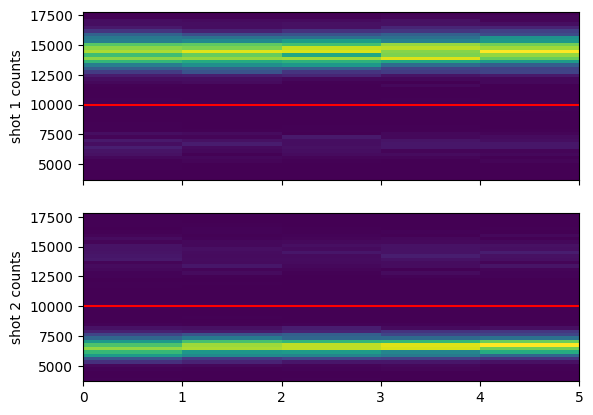

In [6]:
### the file(s) to analyze:
file_indices = {
    11:''
    # 11:'',
} 

compare = True # compare multiple files in the same retention and loading plots
otsu_threshold = False # compute threshold using Otsu method instead doing it by eye. only work when require atom loading = False
showhist = True
showloading = True
custom_xlabel = True
merge_data = False # if True, the datasets will be combined, and if fit=True, the new merged data will be fit. don't try this in 2D
fit = False

showhist_counts = False 

# for plotting
legend_vars =[]   #legend_vars = ['AY_volts_OP', 'f_microwaves_dds'] # will be included in the plot legend
xform_and_label = {}
loc='best'
ret_cmap = mpl.colormaps['turbo']
ldng_cmap = mpl.colormaps['winter']

# for fitting
fit_dict = {}

if compare:
    if showloading:
        fig_ret,axes = plt.subplots(nrows=2, sharex=True)
        ax_ret, ax_ldng = axes
    else:
        fig_ret,ax_ret = plt.subplots()


first_shot_hists = []
second_shot_hists = []
mean1_by_iteration = []
mean2_by_iteration = []

merged_retention = np.array([])
merged_scan_sequence1 = np.array([])
merged_errs = np.array([])
rid_str = ''


for idx,f_item in enumerate(file_indices.items()):
    f_idx,f_comment = f_item   # idx - f_item = {f_idx: f_comment}
    f = h5py.File(os.path.join(results, fnames[f_idx]))
    rid = f['rid'][()]
    h5_archive_and_datasets_to_locals(f, parent_locals=locals(), quiet=True)
    print("experiment:",experiment_function)
    print("override:",override_ExperimentVariables)

    iterations = len(scan_sequence1) #int(len(SPCM0_RO1)/n_measurements)
    print("# of iterations: ", iterations)
    
    if otsu_threshold:
        thresh = threshold_otsu(SPCM0_RO1)
        print("threshold_otsu: ", thresh)
    else:
        cutoff1 = cutoff2 = single_atom_threshold * t_SPCM_first_shot

    
    ### for plotting 
    ### xsteps_xform is a function that can transform scan_sequence1 for plotting. Here it is equal to identity, i.e. no change in scan_sequence1.
    if scan_variable1_name in xform_and_label and custom_xlabel:
        xsteps_xform, xlabel = (xform_and_label[scan_variable1_name]['xsteps_xform'], xform_and_label[scan_variable1_name]['xlabel'])
    else:
        xsteps_xform, xlabel = (lambda x: x, scan_variable1_name)
        

    legend_string = ''
    for a in legend_vars:
        legend_string += f'{a}={locals()[a]}, '
    legend_string = legend_string[:-2]
    f_comment += legend_string

    
    ### get_loading_and_retention
    ### These array have length = iterations
    retention_array, loading_rate_array, n_atoms_loaded_array = get_loading_and_retention(SPCM0_RO1, SPCM0_RO2, n_measurements, iterations, cutoff1, otsu=otsu_threshold)


    ### Necessary to analyze data with 2 scan_sequences
    ### reshaping each array into a 2D array with shape = shape, with order = 'F' (Fortran-style) to sort column by column
    
    ncols = len(scan_sequence2)
    nrows = len(scan_sequence1)
    shape = (len(scan_sequence2),len(scan_sequence1))
    loading_rate_raveled = np.reshape(loading_rate_array,shape,order='F') # rows have constant variable2
    n_atoms_loaded_raveled = np.reshape(n_atoms_loaded_array,shape,order='F') # rows have constant variable2
    retention_raveled = np.reshape(retention_array,shape,order='F') # rows have constant variable2

    
    ### show historam of first_shot and second_shot
    histMin = np.min([SPCM0_RO1, SPCM0_RO2])/t_SPCM_first_shot ## boundary for the histogram plots
    histMax = np.max([SPCM0_RO1, SPCM0_RO2])/t_SPCM_first_shot
    if showhist:
        first_shot_hists.append(
            [np.histogram(SPCM0_RO1[i*n_measurements:(i+1)*n_measurements]/t_SPCM_first_shot,bins=np.linspace(histMin,histMax,50))[0]
                              for i in range(iterations)])

        second_shot_hists.append(
            [np.histogram(SPCM0_RO2[i*n_measurements:(i+1)*n_measurements]/t_SPCM_second_shot,bins=np.linspace(histMin,histMax,50))[0]
                                      for i in range(iterations)])

    
    ### plot a retention curve vs variable 1 for each variable 2 value
    for i, retention, loading, n_loaded, var2 in zip(range(len(scan_sequence2)), retention_raveled, loading_rate_raveled, n_atoms_loaded_raveled, scan_sequence2):
        
        errs = np.array([1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded])
        if not compare:
            if showloading:
                    fig_ret,axes = plt.subplots(nrows=2, sharex=True)
                    ax_ret, ax_ldng = axes
            else:
                fig_ret,ax_ret = plt.subplots()
                
        if not merge_data:
            ax_ret.scatter(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0], label=str(rid)+', '+f_comment, color=ret_cmap(idx/len(file_indices)))
            ax_ret.errorbar(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0], errs[loading > 0], ls='none',color=ret_cmap(idx/len(file_indices)))
            ax_ret.set_ylim((0,1))

            if not ncols > 1 and fit and scan_variable1_name in fit_dict:
                popt, _ = curve_fit(f=fit_dict[scan_variable1_name]['model'], xdata=scan_sequence1, ydata=retention, p0=fit_dict[scan_variable1_name]['p0'], bounds=fit_dict[scan_variable1_name]['bounds'])
                fit_str = "".join([f'{p}={v:.4f}, ' for p,v in zip(fit_dict[scan_variable1_name]['params'], popt)])[:-2]
                print(fit_str)
                hi_res_x = np.linspace(scan_sequence1[0], scan_sequence1[-1], 10*len(scan_sequence1))
                hi_res_x_xform = np.linspace(xsteps_xform(scan_sequence1)[0], xsteps_xform(scan_sequence1)[-1], 10*len(scan_sequence1))
                ax_ret.plot(hi_res_x_xform, fit_dict[scan_variable1_name]['model'](hi_res_x, *popt),linestyle='--',color=ret_cmap(idx/len(file_indices)),label=fit_str)
            else:
                ax_ret.plot(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0],linestyle='--',color=ret_cmap(idx/len(file_indices)))
    
            if not showloading:
                ax_ret.set_xlabel(xlabel)
            ax_ret.set_ylabel("retention")
            #ax_ret.legend(loc=loc)
            ax_ret.legend(bbox_to_anchor=(1.05, 1), loc='upper left')      # This will show the legend outside the plot
            
        else:
            merged_retention = np.concatenate((merged_retention,retention[loading > 0]))
            merged_scan_sequence1 = np.concatenate((merged_scan_sequence1, scan_sequence1[loading > 0]))
            merged_errs = np.concatenate((merged_errs, errs[loading > 0]))
            rid_str += str(rid) + ', '
    
        if showloading:
            ax_ldng.plot(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], linestyle='--',color=ldng_cmap(idx/len(file_indices)))
            ax_ldng.scatter(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], label=rid, color=ldng_cmap(idx/len(file_indices)))
            errs = np.array([1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded])
            ax_ldng.errorbar(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], errs[loading > 0], ls='none', color=ldng_cmap(idx/len(file_indices)))
            ax_ldng.set_ylim((0,1))
            ax_ldng.set_xlabel(xlabel)
            ax_ldng.set_ylabel("loading rate")


if merge_data:
    retention = merged_retention
    scan_sequence1 = merged_scan_sequence1
    errs = merged_errs

    ax_ret.scatter(xsteps_xform(scan_sequence1), retention, color='plum')
    ax_ret.errorbar(xsteps_xform(scan_sequence1), retention, errs, ls='none',color='plum')
    ax_ret.set_ylim((0,1))
    
    if not ncols > 1 and fit and scan_variable1_name in fit_dict:        
        popt, _ = curve_fit(f=fit_dict[scan_variable1_name]['model'], xdata=scan_sequence1, ydata=retention, p0=fit_dict[scan_variable1_name]['p0'], bounds=fit_dict[scan_variable1_name]['bounds'])
        hi_res_x = np.linspace(scan_sequence1[0], scan_sequence1[-1], 10*len(scan_sequence1))
        hi_res_x_xform = np.linspace(xsteps_xform(scan_sequence1)[0], xsteps_xform(scan_sequence1)[-1], 10*len(scan_sequence1))
        fit_str = "".join([f'{p}={v:.4f}, ' for p,v in zip(fit_dict[scan_variable1_name]['params'], popt)])[:-2]
        print(fit_str)
        ax_ret.plot(hi_res_x_xform, fit_dict[scan_variable1_name]['model'](hi_res_x, *popt),linestyle='--',color='violet', label=fit_str)
        ax_ret.legend()
    else:
        ax_ret.plot(xsteps_xform(scan_sequence1), retention,linestyle='--',color='violet')


if not compare or len(file_indices)==1:
    ax_ret.set_title(experiment_function+' '+str(rid))
elif merge_data:
    ax_ret.set_title(experiment_function+' '+ rid_str[:-2])
else:
    ax_ret.set_title(experiment_function)

if showhist:
    fig,axes = plt.subplots(nrows=2,sharex=True)
    ax,ax2 = axes
    cax=ax.imshow(np.array(first_shot_hists[0]).transpose(),origin='lower',extent=[0,iterations,histMin,histMax])
    ax.set_ylabel("shot 1 counts")
    ax.axhline(cutoff1/t_SPCM_first_shot,color='red')
    ax.set_aspect('auto')
    cax2=ax2.imshow(np.array(second_shot_hists[0]).transpose(),origin='lower',extent=[0,iterations,histMin,histMax])
    ax2.set_ylabel("shot 2 counts")
    
    ax2.axhline(cutoff2/t_SPCM_first_shot,color='red')
    ax2.set_aspect('auto')
plt.show()

measured number of counts in iteration 0 = 9289


NameError: name 'atom_counts_i' is not defined

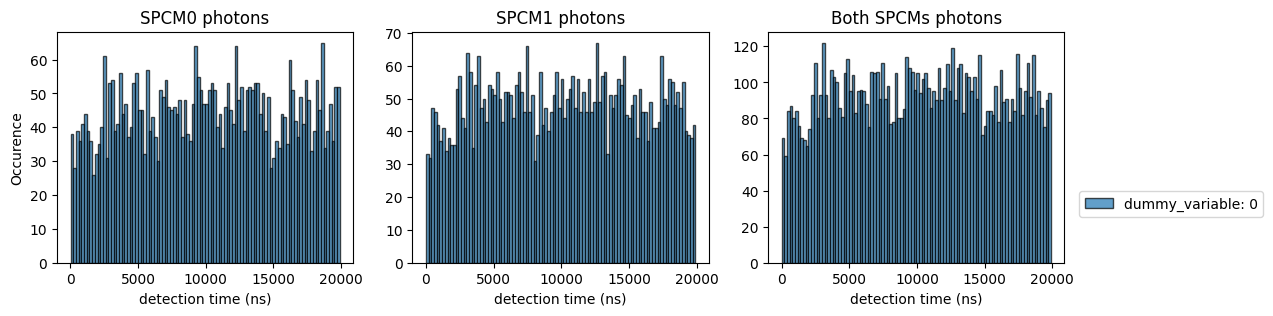

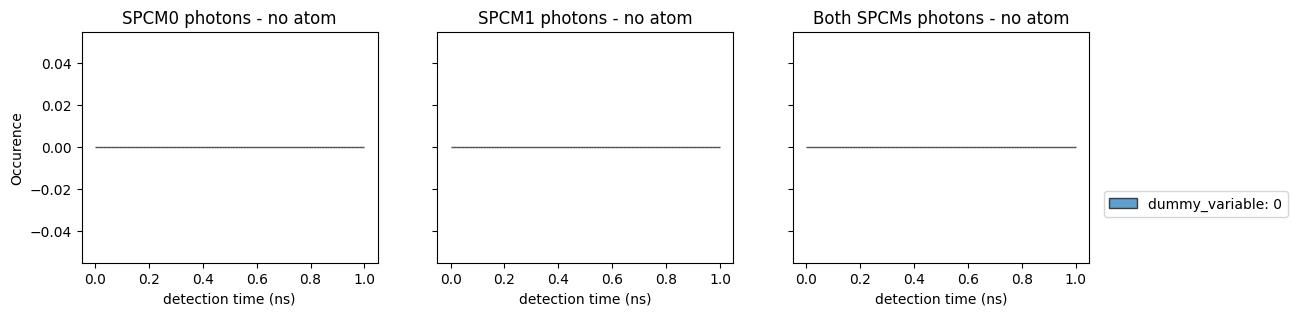

In [7]:
### Print the title of the output
display(HTML(f"""<b style='font-size:18px;'> {date_filters[0]} - RID {rid} - {experiment_function}</b>"""))

max_counts = max(max(SPCM0_SinglePhoton),max(SPCM1_SinglePhoton))+1
bins = list(np.array(list(range(max_counts+1))))  #[0,1,...,max_counts+1]

titles = [f"{scan_variable1_name}: {val}" for val in scan_sequence1]
use_titles = True

binned_data_with_atom = []
binned_data_no_atom = []

atom_counts_all_iterations = np.zeros(iterations)
atom_fraction_all_iterations = np.zeros(iterations)

SPCM0_binned_with_atom_all_iterations = []
SPCM0_binned_no_atom_all_iterations = []

SPCM1_binned_with_atom_all_iterations = []
SPCM1_binned_no_atom_all_iterations = []

g2_0_with_atom = np.zeros(iterations)
g2_0_no_atom = np.zeros(iterations)

g2_0_err_with_atom = np.zeros(iterations)
g2_0_err_no_atom = np.zeros(iterations)


ref_time_t1 = SPCM0_SinglePhoton_tStamps[1:,0] ### the time t1 from the excitation cycle as a reference for timing
SPCM0_SinglePhoton_tStamps_i = SPCM0_SinglePhoton_tStamps[1:,1:]  ###  in SPCM0_SinglePhoton_tStamps the first elements are reference times t1.
SPCM1_SinglePhoton_tStamps_i = SPCM1_SinglePhoton_tStamps[1:]  
readout_i = SPCM0_every_exc_RO[1:]


### SPCM0
SPCM0_timestamps_with_atom_i = np.array([p for p,s in zip(SPCM0_SinglePhoton_tStamps_i, readout_i) if s >= cutoff1]).flatten()
SPCM0_timestamps_no_atom_i = np.array([p for p,s in zip(SPCM0_SinglePhoton_tStamps_i, readout_i) if s < cutoff1]).flatten()
SPCM0_timestamps_with_atom_i = SPCM0_timestamps_with_atom_i[SPCM0_timestamps_with_atom_i != -1.0] - ref_time_t1[0]  ## remove -1 (no click) events
SPCM0_timestamps_no_atom_i = SPCM0_timestamps_no_atom_i[SPCM0_timestamps_no_atom_i != -1.0] - ref_time_t1[0] ### the first t1 is subtracted as the strat time

### SPCM1
SPCM1_timestamps_with_atom_i = np.array([p for p,s in zip(SPCM1_SinglePhoton_tStamps_i, readout_i) if s >= cutoff1]).flatten()
SPCM1_timestamps_no_atom_i = np.array([p for p,s in zip(SPCM1_SinglePhoton_tStamps_i, readout_i) if s < cutoff1]).flatten()
SPCM1_timestamps_with_atom_i = SPCM1_timestamps_with_atom_i[SPCM1_timestamps_with_atom_i != -1.0] - ref_time_t1[0] ## remove -1 (no click) events
SPCM1_timestamps_no_atom_i = SPCM1_timestamps_no_atom_i[SPCM1_timestamps_no_atom_i != -1.0] - ref_time_t1[0] ## remove -1 (no click) events

BothSPCMs_timestamps_with_atom_i = np.concatenate((SPCM0_timestamps_with_atom_i, SPCM1_timestamps_with_atom_i)) 
BothSPCMs_timestamps_no_atom_i = np.concatenate((SPCM0_timestamps_no_atom_i, SPCM1_timestamps_no_atom_i))


### Photons arival time histograms (with atom):
fig, axs = plt.subplots(1, 3, figsize=(13, 3), sharey=False, sharex=True)

axs[0].hist(SPCM0_timestamps_with_atom_i, bins=100, edgecolor='black', alpha=0.7)
# axs[0].set_xlim(250, 500 )
axs[0].set_xlabel("detection time (ns)")
axs[0].set_ylabel("Occurence")
axs[0].set_title("SPCM0 photons")

axs[1].hist(SPCM1_timestamps_with_atom_i, bins=100, edgecolor='black', alpha=0.7)
axs[1].set_xlabel("detection time (ns)")
axs[1].set_title("SPCM1 photons")

axs[2].hist(BothSPCMs_timestamps_with_atom_i, bins=100, edgecolor='black', alpha=0.7, label=f'{scan_variable1_name}: {scan_sequence1[i]}')
axs[2].set_xlabel("detection time (ns)")
axs[2].set_title("Both SPCMs photons")
axs[2].legend(loc=(1.05, 0.2))


### Photons arival time histograms (without atom):
fig, axs = plt.subplots(1, 3, figsize=(13, 3), sharey=True, sharex=True)

axs[0].hist(SPCM0_timestamps_no_atom_i, bins=100, edgecolor='black', alpha=0.7)
# axs[0].set_xlim(250, 500)
axs[0].set_xlabel("detection time (ns)")
axs[0].set_ylabel("Occurence")
axs[0].set_title("SPCM0 photons - no atom")

axs[1].hist(SPCM1_timestamps_no_atom_i, bins=100, edgecolor='black', alpha=0.7)
axs[1].set_xlabel("detection time (ns)")
axs[1].set_title("SPCM1 photons - no atom")

axs[2].hist(BothSPCMs_timestamps_no_atom_i, bins=100, edgecolor='black', alpha=0.7, label=f'{scan_variable1_name}: {scan_sequence1[i]}')
axs[2].set_xlabel("detection time (ns)")
axs[2].set_title("Both SPCMs photons - no atom")
axs[2].legend(loc=(1.05, 0.2))


print(f'measured number of counts in iteration {i} = {len(BothSPCMs_timestamps_with_atom_i)}')
print(f'overal efficiency (%) in iteration {i} = {len(BothSPCMs_timestamps_with_atom_i)/atom_counts_i * 100}')


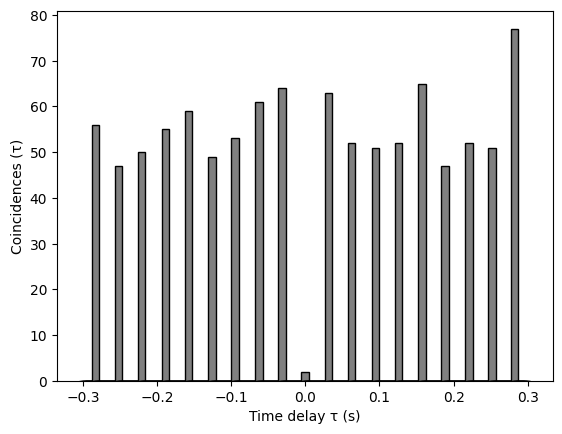

In [8]:
def compute_g2(spcm0_times, spcm1_times, bin_width=1e-3, max_tau=300e-3):
    taus = np.arange(-max_tau, max_tau, bin_width)  # Time bins
    counts, _ = np.histogram(spcm1_times[:, None] - spcm0_times, bins=taus)

    # Normalization (optional, assuming constant background)
    norm_factor = (len(spcm0_times) * len(spcm1_times)) / (2 * max_tau / bin_width)
    # g2 = counts / norm_factor
    g2 = counts

    return taus[:-1] + bin_width / 2, g2, bin_width  # Return bin width for bar plot

taus, g2_values, bin_width = compute_g2(SPCM0_timestamps_with_atom_i, SPCM1_timestamps_with_atom_i)

plt.bar(taus, g2_values, width=10*bin_width, align='center', color='grey', edgecolor='k')
plt.xlabel("Time delay τ (s)")
plt.ylabel("Coincidences (τ)")
plt.show()


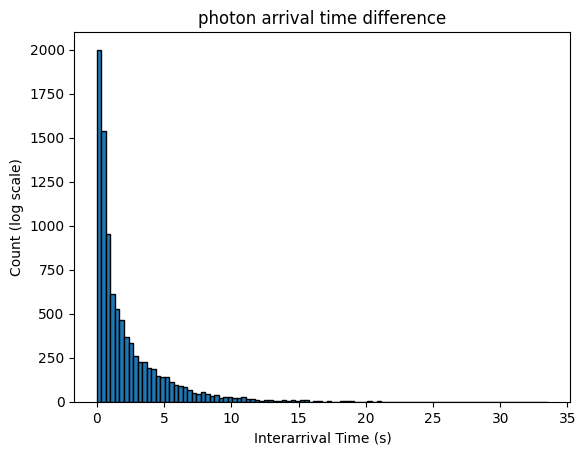

In [39]:
timestamps = np.sort(BothSPCMs_timestamps_with_atom_i)

interarrival_times = np.diff(timestamps)

# Step 3: Define bins (log-spaced bins for better visualization)
bins = np.logspace(np.log10(interarrival_times.min()), np.log10(interarrival_times.max()), 50)

# Plot histogram
plt.hist(interarrival_times, bins=100, edgecolor='black', log=False)  # log=True applies log-scale to y-axis

# Set log scale on x-axis
# plt.xscale("log")

# Labels and title
plt.xlabel("Interarrival Time (s)")
plt.ylabel("Count (log scale)")
plt.title("photon arrival time difference")

# Show the plot
plt.show()

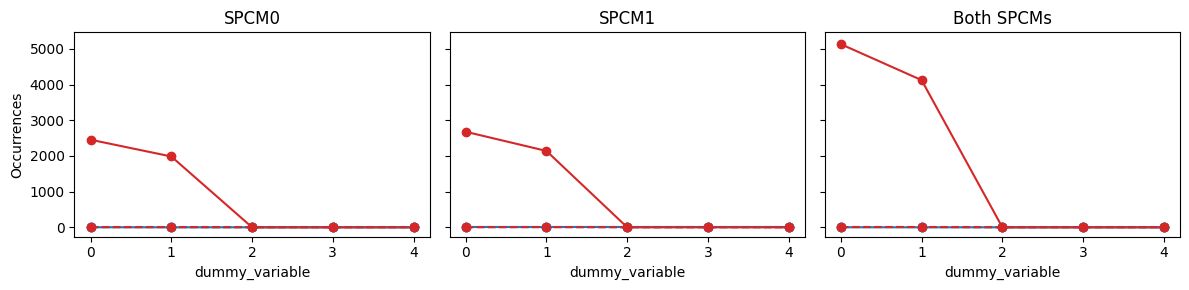

C:\Users\QC\AppData\Local\Temp\ipykernel_13984\1449663314.py:178: RuntimeWarning: invalid value encountered in divide
  no_atom_data_norm = no_atom_data/atom_fraction_all_iterations
C:\Users\QC\AppData\Local\Temp\ipykernel_13984\1449663314.py:179: RuntimeWarning: invalid value encountered in divide
  atom_data_norm = atom_data/atom_fraction_all_iterations


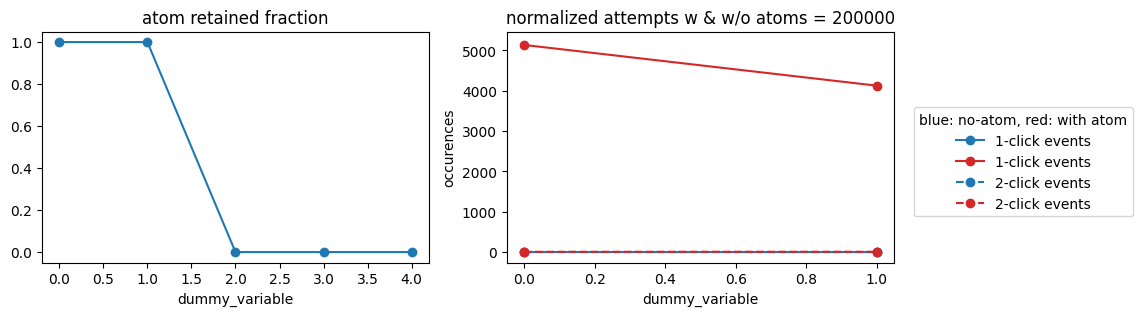

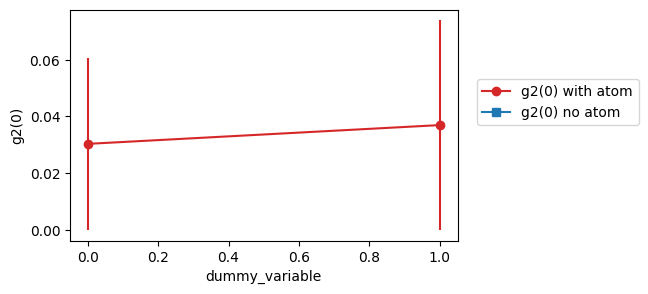

expected number of counts = 10000.0
n_measurements = 1000
n_excitation_cycles = 200
excitation pulse width = 30.000000000000004 ns
SPCM window = 300.0 ns
excitation power set point = 0.01
SPCM gate start offset = 750


In [95]:
max_counts = max(max(SPCM0_SinglePhoton),max(SPCM1_SinglePhoton))+1
bins = list(np.array(list(range(max_counts+1))))  #[0,1,...,max_counts+1]

titles = [f"{scan_variable1_name}: {val}" for val in scan_sequence1]
use_titles = True

binned_data_with_atom = []
binned_data_no_atom = []

atom_counts_all_iterations = np.zeros(iterations)
atom_fraction_all_iterations = np.zeros(iterations)

SPCM0_binned_with_atom_all_iterations = []
SPCM0_binned_no_atom_all_iterations = []

SPCM1_binned_with_atom_all_iterations = []
SPCM1_binned_no_atom_all_iterations = []

g2_0_with_atom = np.zeros(iterations)
g2_0_no_atom = np.zeros(iterations)

g2_0_err_with_atom = np.zeros(iterations)
g2_0_err_no_atom = np.zeros(iterations)

for i in range(iterations):

    ### photons are counted from SPCMs 0 and 1 for the excitation phase
    SPCM0_counts_i = SPCM0_SinglePhoton[1:][n_measurements*n_excitation_cycles*i:(n_measurements*n_excitation_cycles)*(i+1)]
    SPCM1_counts_i = SPCM1_SinglePhoton[1:][n_measurements*n_excitation_cycles*i:(n_measurements*n_excitation_cycles)*(i+1)]
    readout_i = SPCM0_every_exc_RO[1:][n_measurements*n_excitation_cycles*i:(n_measurements*n_excitation_cycles)*(i+1)]
    
    ### SPCM0
    SPCM0_counts_with_atom_i = np.array([p for p,s in zip(SPCM0_counts_i, readout_i) if s > cutoff1]).flatten()
    SPCM0_counts_no_atom_i = np.array([p for p,s in zip(SPCM0_counts_i, readout_i) if s <= cutoff1]).flatten()
    
    ### SPCM1
    SPCM1_counts_with_atom_i = np.array([p for p,s in zip(SPCM1_counts_i, readout_i) if s > cutoff1]).flatten()
    SPCM1_counts_no_atom_i = np.array([p for p,s in zip(SPCM1_counts_i, readout_i) if s <= cutoff1]).flatten()

    ### Calculate g2(0) for the current iteration
    ### with atom:
    n_coincidence_with_atom_i = np.sum((SPCM0_counts_with_atom_i >= 1) & (SPCM1_counts_with_atom_i >= 1))
    n_SPCM0_counts_with_atom_i = np.sum(SPCM0_counts_with_atom_i >= 1)
    n_SPCM1_counts_with_atom_i = np.sum(SPCM1_counts_with_atom_i >= 1)
    n_trial = len(SPCM0_counts_with_atom_i) 

    if n_SPCM0_counts_with_atom_i > 0 and n_SPCM1_counts_with_atom_i > 0:
        g2_0 = (n_coincidence_with_atom_i / 
                  (n_SPCM0_counts_with_atom_i * n_SPCM1_counts_with_atom_i)) * n_trial
        ### Errors for g2 results are from error propagation assuming Poissonian distribution for counts:
        if n_coincidence_with_atom_i > 0:
            g2_0_err = g2_0 * np.sqrt(1/n_coincidence_with_atom_i + 1/n_SPCM0_counts_with_atom_i + 1/n_SPCM1_counts_with_atom_i)
        else:
            g2_0_err = np.nan
    else:
        g2_0 = np.nan 
        g2_0_err = np.nan
    g2_0_with_atom[i] = g2_0
    g2_0_err_with_atom[i] = g2_0_err

    ### without atom:
    n_coincidence_no_atom_i = np.sum((SPCM0_counts_no_atom_i >= 1) & (SPCM1_counts_no_atom_i >= 1))
    n_SPCM0_counts_no_atom_i = np.sum(SPCM0_counts_no_atom_i >= 1)
    n_SPCM1_counts_no_atom_i = np.sum(SPCM1_counts_no_atom_i >= 1)
    n_trial = len(SPCM0_counts_no_atom_i) 

    if n_SPCM0_counts_no_atom_i > 0 and n_SPCM1_counts_no_atom_i > 0:
        g2_0 = (n_coincidence_no_atom_i / 
                  (n_SPCM0_counts_no_atom_i * n_SPCM1_counts_no_atom_i)) * n_trial
        if n_coincidence_no_atom_i > 0:
            g2_0_err = g2_0 * np.sqrt(1/n_coincidence_no_atom_i + 1/n_SPCM0_counts_no_atom_i + 1/n_SPCM1_counts_no_atom_i)
        else:
            g2_0_err = np.nan
    else:
        g2_0 = np.nan
        g2_0_err = np.nan
    g2_0_no_atom[i] = g2_0
    g2_0_err_no_atom[i] = g2_0_err
    

    ### for normalization
    atom_counts_i = 0 # number of atoms retained in each iteration
    for val in readout_i:
        if val > cutoff1:
            atom_counts_i += 1
    atom_counts_all_iterations[i] = atom_counts_i
    if len(readout_i) > 0:
        atom_fraction_all_iterations[i] = atom_counts_i / len(readout_i)

    ### Binning for counting photon clicks
    SPCM0_binned_with_atom_i = np.histogram(SPCM0_counts_with_atom_i, bins=bins)[0]
    SPCM0_binned_with_atom_all_iterations.append(SPCM0_binned_with_atom_i)

    SPCM0_binned_no_atom_i = np.histogram(SPCM0_counts_no_atom_i, bins=bins)[0]
    SPCM0_binned_no_atom_all_iterations.append(SPCM0_binned_no_atom_i)

    SPCM1_binned_with_atom_i = np.histogram(SPCM1_counts_with_atom_i, bins=bins)[0]
    SPCM1_binned_with_atom_all_iterations.append(SPCM1_binned_with_atom_i)

    SPCM1_binned_no_atom_i = np.histogram(SPCM1_counts_no_atom_i, bins=bins)[0]
    SPCM1_binned_no_atom_all_iterations.append(SPCM1_binned_no_atom_i)


### transposing the array for plotting and removing 0 counts:
SPCM0_binned_with_atom_all_iterations_trans = np.array(SPCM0_binned_with_atom_all_iterations).transpose()[1:]
SPCM0_binned_no_atom_all_iterations_trans = np.array(SPCM0_binned_no_atom_all_iterations).transpose()[1:]

SPCM1_binned_with_atom_all_iterations_trans = np.array(SPCM1_binned_with_atom_all_iterations).transpose()[1:]
SPCM1_binned_no_atom_all_iterations_trans = np.array(SPCM1_binned_no_atom_all_iterations).transpose()[1:]

SPCM1and2_binned_with_atom_all_iterations_trans = SPCM0_binned_with_atom_all_iterations_trans + SPCM1_binned_with_atom_all_iterations_trans
SPCM1and2_binned_no_atom_all_iterations_trans = SPCM0_binned_no_atom_all_iterations_trans + SPCM1_binned_no_atom_all_iterations_trans

### Print the title of the output
display(HTML(f"""<b style='font-size:18px;'> {date_filters[0]} - RID {rid} - {experiment_function}</b>"""))


### Un-normalized plots
fig, axs = plt.subplots(1, 3, figsize=(12, 3), sharey=True)
linestyles = ['solid','dashed','dotted','dashdot','dashdot','dashdot','dashdot']

### First plot (SPCM0)
atom_data = SPCM0_binned_with_atom_all_iterations_trans
no_atom_data = SPCM0_binned_no_atom_all_iterations_trans
for i in range(max(bins)-1):
    axs[0].plot(scan_sequence1, no_atom_data[i], label=f'{i+1}-click events', ls=linestyles[i], color='tab:blue', marker='o')
    axs[0].plot(scan_sequence1, atom_data[i], label=f'{i+1}-click events', ls=linestyles[i], color='tab:red', marker='o')
    axs[0].errorbar(scan_sequence1, no_atom_data[i], yerr=[np.sqrt(x) if x > 0 else np.inf for x in no_atom_data[i]], ls='none', color='tab:blue')
    axs[0].errorbar(scan_sequence1, atom_data[i], yerr=[np.sqrt(x) if x > 0 else np.inf for x in atom_data[i]], ls='none', color='tab:red')

axs[0].set_title('SPCM0')
axs[0].set_ylabel('Occurrences')
axs[0].set_xlabel(scan_variable1_name)


### Second plot (SPCM1)
atom_data = SPCM1_binned_with_atom_all_iterations_trans
no_atom_data = SPCM1_binned_no_atom_all_iterations_trans
for i in range(max(bins)-1):
    axs[1].plot(scan_sequence1, no_atom_data[i], label=f'{i+1}-click events', ls=linestyles[i], color='tab:blue', marker='o')
    axs[1].plot(scan_sequence1, atom_data[i], label=f'{i+1}-click events', ls=linestyles[i], color='tab:red', marker='o')
    axs[1].errorbar(scan_sequence1, no_atom_data[i], yerr=[np.sqrt(x) if x > 0 else np.inf for x in no_atom_data[i]], ls='none', color='tab:blue')
    axs[1].errorbar(scan_sequence1, atom_data[i], yerr=[np.sqrt(x) if x > 0 else np.inf for x in atom_data[i]], ls='none', color='tab:red')

axs[1].set_title('SPCM1')
axs[1].set_xlabel(scan_variable1_name)


### 3rd plot (Both SPCMs)
atom_data = SPCM1and2_binned_with_atom_all_iterations_trans
no_atom_data = SPCM1and2_binned_no_atom_all_iterations_trans
for i in range(max(bins)-1):
    axs[2].plot(scan_sequence1, no_atom_data[i], label=f'{i+1}-click events', ls=linestyles[i], color='tab:blue', marker='o')
    axs[2].plot(scan_sequence1, atom_data[i], label=f'{i+1}-click events', ls=linestyles[i], color='tab:red', marker='o')
    axs[2].errorbar(scan_sequence1, no_atom_data[i], yerr=[np.sqrt(x) if x > 0 else np.inf for x in no_atom_data[i]], ls='none', color='tab:blue')
    axs[2].errorbar(scan_sequence1, atom_data[i], yerr=[np.sqrt(x) if x > 0 else np.inf for x in atom_data[i]], ls='none', color='tab:red')

axs[2].set_title('Both SPCMs')
axs[2].set_xlabel(scan_variable1_name)
# axs[2].set_xlim(500,1200)
# axs[2].legend(loc=(1.05, 0.2), title='blue: no-atom, red: with atom')

plt.tight_layout()
plt.show()


### atom retained fraction:
fig, axs = plt.subplots(1, 2, figsize=(11, 3))
axs[0].plot(scan_sequence1,atom_fraction_all_iterations, marker='o')
axs[0].set_xlabel(scan_variable1_name)
axs[0].set_title("atom retained fraction")


### normalized both SPCMs:
atom_data = SPCM1and2_binned_with_atom_all_iterations_trans
no_atom_data = SPCM1and2_binned_no_atom_all_iterations_trans

no_atom_data_norm = no_atom_data/atom_fraction_all_iterations
atom_data_norm = atom_data/atom_fraction_all_iterations


for i in range(max(bins)-1):
    axs[1].plot(scan_sequence1, no_atom_data_norm[i],label=f'{i+1}-click events',ls=linestyles[i],color='tab:blue', marker='o')
    axs[1].plot(scan_sequence1, atom_data_norm[i],label=f'{i+1}-click events',ls=linestyles[i],color='tab:red', marker='o')
    axs[1].errorbar(scan_sequence1, no_atom_data_norm[i], yerr=[np.sqrt(x) if x > 0 else np.inf for x in no_atom_data_norm[i]], ls='none',color='tab:blue')
    axs[1].errorbar(scan_sequence1, atom_data_norm[i], yerr=[np.sqrt(x) if x > 0 else np.inf for x in atom_data_norm[i]], ls='none',color='tab:red')
axs[1].legend(loc=(1.05,0.2), title = 'blue: no-atom, red: with atom')
axs[1].set_title(f'normalized attempts w & w/o atoms = {n_excitation_cycles * n_measurements}')
axs[1].set_ylabel('occurences')
axs[1].set_xlabel(scan_variable1_name)
plt.show()


### Plot g2
plt.figure(figsize=(5, 3))
plt.plot(scan_sequence1, g2_0_with_atom, label='g2(0) with atom', marker='o', color='tab:red')
plt.plot(scan_sequence1, g2_0_no_atom, label='g2(0) no atom', marker='s', color='tab:blue')
plt.errorbar(scan_sequence1, g2_0_with_atom, yerr=g2_0_err_with_atom, ls='none',color='tab:red')
plt.errorbar(scan_sequence1, g2_0_no_atom, yerr=g2_0_err_no_atom, ls='none',color='tab:blue')
plt.legend(loc=(1.05,0.5))
plt.xlabel(scan_variable1_name)
plt.ylabel('g2(0)')
plt.show()


Col_Eff = 0.05 # overal expected/theoretical collection and detection efficiency 
print(f'expected number of counts = {n_excitation_cycles * n_measurements * Col_Eff}')
print(f'n_measurements = {n_measurements}')
print(f'n_excitation_cycles = {n_excitation_cycles}')
print(f'excitation pulse width = {t_excitation_pulse/10**-9}','ns')
print(f'SPCM window = {t_photon_collection_time/10**-9}', 'ns')
print(f'excitation power set point = {set_point_excitation}')
print(f'SPCM gate start offset = {gate_start_offset_mu}')


# Single photon analysis - Readout every excitation cycle (with new variable names such as SPCM0_RO1)
Using the old sequence for atom loading: Turning on MOT and FORT for 500ms, if no atom is trapped, try another cycle. valid for experiments until 2025-02-14.

Analysis for our first search for photons emitted following an excitation pulse, with $g^{(2)}(0)$ calculations. 

To use the analysis code, change the dat in date_filters and find the experiment(s) you want to analyse and write in file_indices. If you like the results and you want to keep them, take a screen clip of the results and save in the powerpoint. All the information you need to know about the experiment should be printed at the end. Please add anything is missing.

In [19]:
date_filters = ["2025-02-14"]

from matplotlib import pyplot as plt
import matplotlib as mpl
from matplotlib.lines import Line2D
import csv
import numpy as np
import os,sys
import PIL # for reading tif images
import h5py
import datetime as dt
import time
from scipy.optimize import curve_fit
from skimage.filters import threshold_otsu
from IPython.display import display, HTML ## for large prints

sys.path.append("..\\")
from h5_data_utilities import * # helper functions for dealing with h5 files

def average_over_measurement(measurements, history):
    iteration = len(history) // measurements
    mean_by_iteration = [np.mean(history[j * measurements:(j + 1) * measurements]) for j in range(iteration)]
    return mean_by_iteration


fnames = get_files_by_criteria(date_filters, # only find files from these date directories
                               name_filters=["GeneralVariableScan"], # only find files containing all these strings
                               condition=lambda filename: True, # use this to filter by experiment parameters, like this: lambda filename: np.bool_(h5py.File(filename)['datasets']['set_current_coil_volts_at_finish'])
                               start_dir=results,
                               include_path=True, # if False, only return the name of the file, not the full path
                               print_filenames=True
)


only_show_i_greater_than = -1

print(f"found {len(fnames)} files")
for i,f in enumerate(fnames):
    if i > only_show_i_greater_than:
        try:
            ds = h5py.File(os.path.join(results, f))['datasets']
            scan_str = str_from_h5(ds['scan_variable1_name'])
            if str_from_h5(ds['scan_variable2_name']) != '':
                scan_str += ", " +str_from_h5(ds['scan_variable2_name'])
            print(f"file {i} ({f}) scanned over "+scan_str)
        except:

            print(f"oops... something wrong with {f}")

skipping C:\Networking Experiment\artiq codes\artiq-master\results\2025-02-14\17\000022251-GeneralVariableScan.h5, which is corrupt
found 27 files
file 0 (C:\Networking Experiment\artiq codes\artiq-master\results\2025-02-14\13\000022192-GeneralVariableScan.h5) scanned over t_microwave_pulse
file 1 (C:\Networking Experiment\artiq codes\artiq-master\results\2025-02-14\13\000022195-GeneralVariableScan.h5) scanned over t_microwave_pulse
file 2 (C:\Networking Experiment\artiq codes\artiq-master\results\2025-02-14\13\000022202-GeneralVariableScan.h5) scanned over t_microwave_pulse
file 3 (C:\Networking Experiment\artiq codes\artiq-master\results\2025-02-14\13\000022202-GeneralVariableScan_microwave_Rabi_scan_over_t_microwave_pulse.h5) scanned over t_microwave_pulse
file 4 (C:\Networking Experiment\artiq codes\artiq-master\results\2025-02-14\13\000022207-GeneralVariableScan.h5) scanned over t_microwave_pulse
file 5 (C:\Networking Experiment\artiq codes\artiq-master\results\2025-02-14\13\00002

experiment: single_photon_experiment_2_atom_loading_advance
override: {'dummy_variable':4}
# of iterations:  1


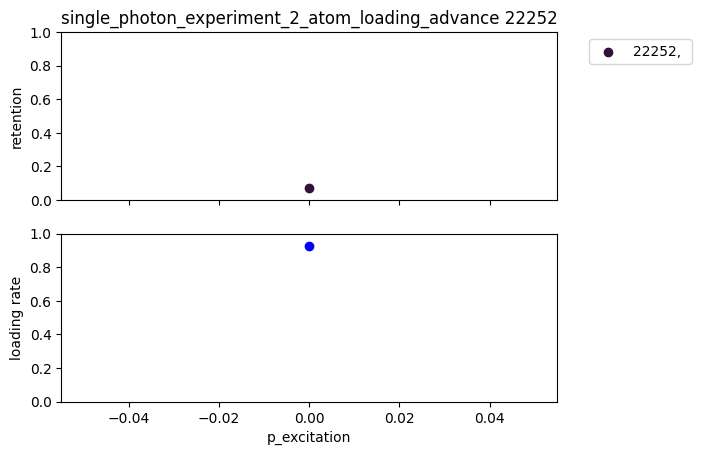

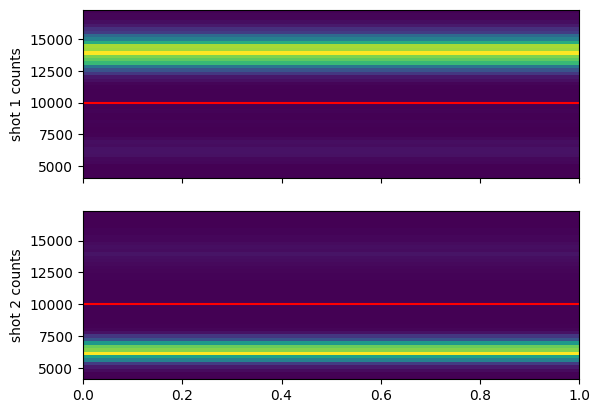

In [2]:
### the file(s) to analyze:
file_indices = {
    26:'',
    # 47:''
    # 48:''
} 

compare = True # compare multiple files in the same retention and loading plots
otsu_threshold = False # compute threshold using Otsu method instead doing it by eye. only work when require atom loading = False
showhist = True
showloading = True
custom_xlabel = True
merge_data = False # if True, the datasets will be combined, and if fit=True, the new merged data will be fit. don't try this in 2D
fit = False

showhist_counts = False 

# for plotting
legend_vars =[]   #legend_vars = ['AY_volts_OP', 'f_microwaves_dds'] # will be included in the plot legend
xform_and_label = {}
loc='best'
ret_cmap = mpl.colormaps['turbo']
ldng_cmap = mpl.colormaps['winter']

# for fitting
fit_dict = {}

if compare:
    if showloading:
        fig_ret,axes = plt.subplots(nrows=2, sharex=True)
        ax_ret, ax_ldng = axes
    else:
        fig_ret,ax_ret = plt.subplots()


first_shot_hists = []
second_shot_hists = []
mean1_by_iteration = []
mean2_by_iteration = []

merged_retention = np.array([])
merged_scan_sequence1 = np.array([])
merged_errs = np.array([])
rid_str = ''


for idx,f_item in enumerate(file_indices.items()):
    f_idx,f_comment = f_item   # idx - f_item = {f_idx: f_comment}
    f = h5py.File(os.path.join(results, fnames[f_idx]))
    rid = f['rid'][()]
    h5_archive_and_datasets_to_locals(f, parent_locals=locals(), quiet=True)
    print("experiment:",experiment_function)
    print("override:",override_ExperimentVariables)

    iterations = len(scan_sequence1) #int(len(SPCM0_RO1)/n_measurements)
    print("# of iterations: ", iterations)
    
    if otsu_threshold:
        thresh = threshold_otsu(SPCM0_RO1)
        print("threshold_otsu: ", thresh)
    else:
        cutoff1 = cutoff2 = single_atom_threshold * t_SPCM_first_shot

    
    ### for plotting 
    ### xsteps_xform is a function that can transform scan_sequence1 for plotting. Here it is equal to identity, i.e. no change in scan_sequence1.
    if scan_variable1_name in xform_and_label and custom_xlabel:
        xsteps_xform, xlabel = (xform_and_label[scan_variable1_name]['xsteps_xform'], xform_and_label[scan_variable1_name]['xlabel'])
    else:
        xsteps_xform, xlabel = (lambda x: x, scan_variable1_name)
        

    legend_string = ''
    for a in legend_vars:
        legend_string += f'{a}={locals()[a]}, '
    legend_string = legend_string[:-2]
    f_comment += legend_string

    
    ### get_loading_and_retention
    ### These array have length = iterations
    retention_array, loading_rate_array, n_atoms_loaded_array = get_loading_and_retention(SPCM0_RO1, SPCM0_RO2, n_measurements, iterations, cutoff1, otsu=otsu_threshold)


    ### Necessary to analyze data with 2 scan_sequences
    ### reshaping each array into a 2D array with shape = shape, with order = 'F' (Fortran-style) to sort column by column
    
    ncols = len(scan_sequence2)
    nrows = len(scan_sequence1)
    shape = (len(scan_sequence2),len(scan_sequence1))
    loading_rate_raveled = np.reshape(loading_rate_array,shape,order='F') # rows have constant variable2
    n_atoms_loaded_raveled = np.reshape(n_atoms_loaded_array,shape,order='F') # rows have constant variable2
    retention_raveled = np.reshape(retention_array,shape,order='F') # rows have constant variable2

    
    ### show historam of first_shot and second_shot
    histMin = np.min([SPCM0_RO1, SPCM0_RO2])/t_SPCM_first_shot ## boundary for the histogram plots
    histMax = np.max([SPCM0_RO1, SPCM0_RO2])/t_SPCM_first_shot
    if showhist:
        first_shot_hists.append(
            [np.histogram(SPCM0_RO1[i*n_measurements:(i+1)*n_measurements]/t_SPCM_first_shot,bins=np.linspace(histMin,histMax,50))[0]
                              for i in range(iterations)])

        second_shot_hists.append(
            [np.histogram(SPCM0_RO2[i*n_measurements:(i+1)*n_measurements]/t_SPCM_second_shot,bins=np.linspace(histMin,histMax,50))[0]
                                      for i in range(iterations)])

    
    ### plot a retention curve vs variable 1 for each variable 2 value
    for i, retention, loading, n_loaded, var2 in zip(range(len(scan_sequence2)), retention_raveled, loading_rate_raveled, n_atoms_loaded_raveled, scan_sequence2):
        
        errs = np.array([1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded])
        if not compare:
            if showloading:
                    fig_ret,axes = plt.subplots(nrows=2, sharex=True)
                    ax_ret, ax_ldng = axes
            else:
                fig_ret,ax_ret = plt.subplots()
                
        if not merge_data:
            ax_ret.scatter(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0], label=str(rid)+', '+f_comment, color=ret_cmap(idx/len(file_indices)))
            ax_ret.errorbar(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0], errs[loading > 0], ls='none',color=ret_cmap(idx/len(file_indices)))
            ax_ret.set_ylim((0,1))

            if not ncols > 1 and fit and scan_variable1_name in fit_dict:
                popt, _ = curve_fit(f=fit_dict[scan_variable1_name]['model'], xdata=scan_sequence1, ydata=retention, p0=fit_dict[scan_variable1_name]['p0'], bounds=fit_dict[scan_variable1_name]['bounds'])
                fit_str = "".join([f'{p}={v:.4f}, ' for p,v in zip(fit_dict[scan_variable1_name]['params'], popt)])[:-2]
                print(fit_str)
                hi_res_x = np.linspace(scan_sequence1[0], scan_sequence1[-1], 10*len(scan_sequence1))
                hi_res_x_xform = np.linspace(xsteps_xform(scan_sequence1)[0], xsteps_xform(scan_sequence1)[-1], 10*len(scan_sequence1))
                ax_ret.plot(hi_res_x_xform, fit_dict[scan_variable1_name]['model'](hi_res_x, *popt),linestyle='--',color=ret_cmap(idx/len(file_indices)),label=fit_str)
            else:
                ax_ret.plot(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0],linestyle='--',color=ret_cmap(idx/len(file_indices)))
    
            if not showloading:
                ax_ret.set_xlabel(xlabel)
            ax_ret.set_ylabel("retention")
            #ax_ret.legend(loc=loc)
            ax_ret.legend(bbox_to_anchor=(1.05, 1), loc='upper left')      # This will show the legend outside the plot
            
        else:
            merged_retention = np.concatenate((merged_retention,retention[loading > 0]))
            merged_scan_sequence1 = np.concatenate((merged_scan_sequence1, scan_sequence1[loading > 0]))
            merged_errs = np.concatenate((merged_errs, errs[loading > 0]))
            rid_str += str(rid) + ', '
    
        if showloading:
            ax_ldng.plot(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], linestyle='--',color=ldng_cmap(idx/len(file_indices)))
            ax_ldng.scatter(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], label=rid, color=ldng_cmap(idx/len(file_indices)))
            errs = np.array([1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded])
            ax_ldng.errorbar(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], errs[loading > 0], ls='none', color=ldng_cmap(idx/len(file_indices)))
            ax_ldng.set_ylim((0,1))
            ax_ldng.set_xlabel(xlabel)
            ax_ldng.set_ylabel("loading rate")


if merge_data:
    retention = merged_retention
    scan_sequence1 = merged_scan_sequence1
    errs = merged_errs

    ax_ret.scatter(xsteps_xform(scan_sequence1), retention, color='plum')
    ax_ret.errorbar(xsteps_xform(scan_sequence1), retention, errs, ls='none',color='plum')
    ax_ret.set_ylim((0,1))
    
    if not ncols > 1 and fit and scan_variable1_name in fit_dict:        
        popt, _ = curve_fit(f=fit_dict[scan_variable1_name]['model'], xdata=scan_sequence1, ydata=retention, p0=fit_dict[scan_variable1_name]['p0'], bounds=fit_dict[scan_variable1_name]['bounds'])
        hi_res_x = np.linspace(scan_sequence1[0], scan_sequence1[-1], 10*len(scan_sequence1))
        hi_res_x_xform = np.linspace(xsteps_xform(scan_sequence1)[0], xsteps_xform(scan_sequence1)[-1], 10*len(scan_sequence1))
        fit_str = "".join([f'{p}={v:.4f}, ' for p,v in zip(fit_dict[scan_variable1_name]['params'], popt)])[:-2]
        print(fit_str)
        ax_ret.plot(hi_res_x_xform, fit_dict[scan_variable1_name]['model'](hi_res_x, *popt),linestyle='--',color='violet', label=fit_str)
        ax_ret.legend()
    else:
        ax_ret.plot(xsteps_xform(scan_sequence1), retention,linestyle='--',color='violet')


if not compare or len(file_indices)==1:
    ax_ret.set_title(experiment_function+' '+str(rid))
elif merge_data:
    ax_ret.set_title(experiment_function+' '+ rid_str[:-2])
else:
    ax_ret.set_title(experiment_function)

if showhist:
    fig,axes = plt.subplots(nrows=2,sharex=True)
    ax,ax2 = axes
    cax=ax.imshow(np.array(first_shot_hists[0]).transpose(),origin='lower',extent=[0,iterations,histMin,histMax])
    ax.set_ylabel("shot 1 counts")
    ax.axhline(cutoff1/t_SPCM_first_shot,color='red')
    ax.set_aspect('auto')
    cax2=ax2.imshow(np.array(second_shot_hists[0]).transpose(),origin='lower',extent=[0,iterations,histMin,histMax])
    ax2.set_ylabel("shot 2 counts")
    
    ax2.axhline(cutoff2/t_SPCM_first_shot,color='red')
    ax2.set_aspect('auto')
plt.show()

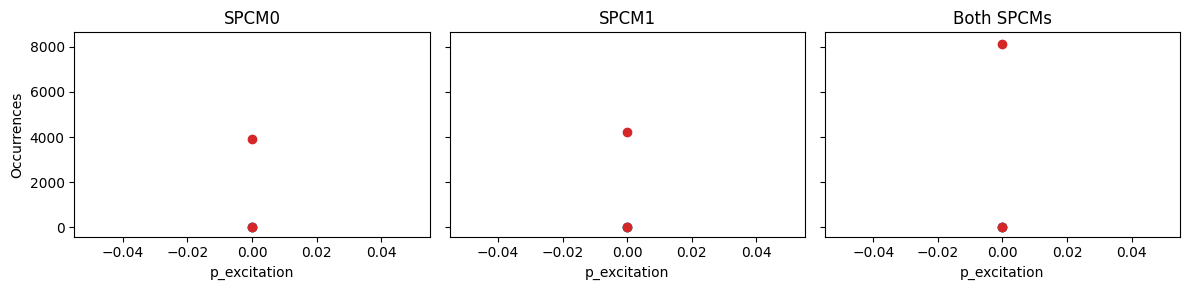

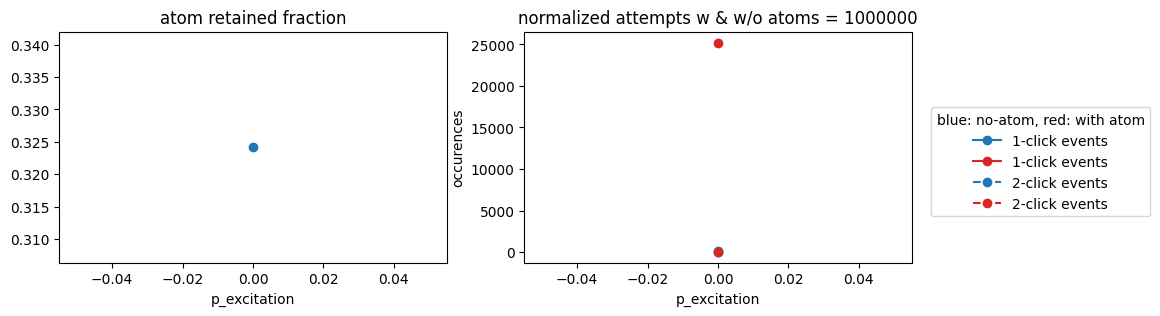

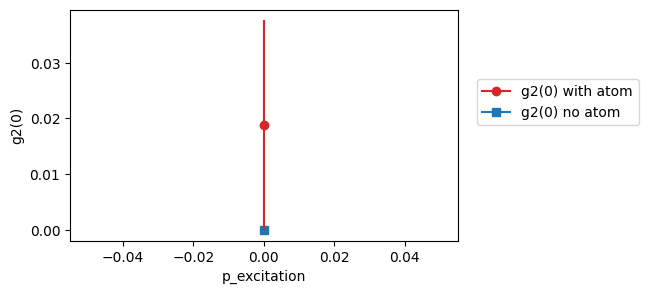

expected number of counts = 50000.0
n_measurements = 5000
n_excitation_cycles = 200
excitation pulse width = 30.000000000000004 ns
SPCM window = 300.0 ns
excitation power set point = 0.01
SPCM gate start offset = 750


In [20]:
max_counts = max(max(SPCM0_SinglePhoton),max(SPCM1_SinglePhoton))+1
bins = list(np.array(list(range(max_counts+1))))  #[0,1,...,max_counts+1]

titles = [f"{scan_variable1_name}: {val}" for val in scan_sequence1]
use_titles = True

binned_data_with_atom = []
binned_data_no_atom = []

atom_counts_all_iterations = np.zeros(iterations)
atom_fraction_all_iterations = np.zeros(iterations)

SPCM0_binned_with_atom_all_iterations = []
SPCM0_binned_no_atom_all_iterations = []

SPCM1_binned_with_atom_all_iterations = []
SPCM1_binned_no_atom_all_iterations = []

g2_0_with_atom = np.zeros(iterations)
g2_0_no_atom = np.zeros(iterations)

g2_0_err_with_atom = np.zeros(iterations)
g2_0_err_no_atom = np.zeros(iterations)

for i in range(iterations):

    ### photons are counted from SPCMs 0 and 1 for the excitation phase
    SPCM0_counts_i = SPCM0_SinglePhoton[1:][n_measurements*n_excitation_cycles*i:(n_measurements*n_excitation_cycles)*(i+1)]
    SPCM1_counts_i = SPCM1_SinglePhoton[1:][n_measurements*n_excitation_cycles*i:(n_measurements*n_excitation_cycles)*(i+1)]
    readout_i = SPCM0_every_exc_RO[1:][n_measurements*n_excitation_cycles*i:(n_measurements*n_excitation_cycles)*(i+1)]
    
    ### SPCM0
    SPCM0_counts_with_atom_i = np.array([p for p,s in zip(SPCM0_counts_i, readout_i) if s > cutoff1]).flatten()
    SPCM0_counts_no_atom_i = np.array([p for p,s in zip(SPCM0_counts_i, readout_i) if s <= cutoff1]).flatten()
    
    ### SPCM1
    SPCM1_counts_with_atom_i = np.array([p for p,s in zip(SPCM1_counts_i, readout_i) if s > cutoff1]).flatten()
    SPCM1_counts_no_atom_i = np.array([p for p,s in zip(SPCM1_counts_i, readout_i) if s <= cutoff1]).flatten()

    ### Calculate g2(0) for the current iteration
    ### with atom:
    n_coincidence_with_atom_i = np.sum((SPCM0_counts_with_atom_i >= 1) & (SPCM1_counts_with_atom_i >= 1))
    n_SPCM0_counts_with_atom_i = np.sum(SPCM0_counts_with_atom_i >= 1)
    n_SPCM1_counts_with_atom_i = np.sum(SPCM1_counts_with_atom_i >= 1)
    n_trial_atom = len(SPCM0_counts_with_atom_i) 

    if n_SPCM0_counts_with_atom_i > 0 and n_SPCM1_counts_with_atom_i > 0:
        g2_0 = (n_coincidence_with_atom_i / 
                  (n_SPCM0_counts_with_atom_i * n_SPCM1_counts_with_atom_i)) * n_trial_atom
        ### Errors for g2 results are from error propagation assuming Poissonian distribution for counts:
        if n_coincidence_with_atom_i > 0:
            g2_0_err = g2_0 * np.sqrt(1/n_coincidence_with_atom_i + 1/n_SPCM0_counts_with_atom_i + 1/n_SPCM1_counts_with_atom_i)
        else:
            g2_0_err = np.nan
    else:
        g2_0 = np.nan 
        g2_0_err = np.nan
    g2_0_with_atom[i] = g2_0
    g2_0_err_with_atom[i] = g2_0_err

    ### without atom:
    n_coincidence_no_atom_i = np.sum((SPCM0_counts_no_atom_i >= 1) & (SPCM1_counts_no_atom_i >= 1))
    n_SPCM0_counts_no_atom_i = np.sum(SPCM0_counts_no_atom_i >= 1)
    n_SPCM1_counts_no_atom_i = np.sum(SPCM1_counts_no_atom_i >= 1)
    n_trial_no_atom = len(SPCM0_counts_no_atom_i) 

    if n_SPCM0_counts_no_atom_i > 0 and n_SPCM1_counts_no_atom_i > 0:
        g2_0 = (n_coincidence_no_atom_i / 
                  (n_SPCM0_counts_no_atom_i * n_SPCM1_counts_no_atom_i)) * n_trial_no_atom
        if n_coincidence_no_atom_i > 0:
            g2_0_err = g2_0 * np.sqrt(1/n_coincidence_no_atom_i + 1/n_SPCM0_counts_no_atom_i + 1/n_SPCM1_counts_no_atom_i)
        else:
            g2_0_err = np.nan
    else:
        g2_0 = np.nan
        g2_0_err = np.nan
    g2_0_no_atom[i] = g2_0
    g2_0_err_no_atom[i] = g2_0_err
    

    ### for normalization
    atom_counts_i = 0 # number of atoms retained in each iteration
    for val in readout_i:
        if val > cutoff1:
            atom_counts_i += 1
    atom_counts_all_iterations[i] = atom_counts_i
    if len(readout_i) > 0:
        atom_fraction_all_iterations[i] = atom_counts_i / len(readout_i)

    ### Binning for counting photon clicks
    SPCM0_binned_with_atom_i = np.histogram(SPCM0_counts_with_atom_i, bins=bins)[0]
    SPCM0_binned_with_atom_all_iterations.append(SPCM0_binned_with_atom_i)

    SPCM0_binned_no_atom_i = np.histogram(SPCM0_counts_no_atom_i, bins=bins)[0]
    SPCM0_binned_no_atom_all_iterations.append(SPCM0_binned_no_atom_i)

    SPCM1_binned_with_atom_i = np.histogram(SPCM1_counts_with_atom_i, bins=bins)[0]
    SPCM1_binned_with_atom_all_iterations.append(SPCM1_binned_with_atom_i)

    SPCM1_binned_no_atom_i = np.histogram(SPCM1_counts_no_atom_i, bins=bins)[0]
    SPCM1_binned_no_atom_all_iterations.append(SPCM1_binned_no_atom_i)


### transposing the array for plotting and removing 0 counts:
SPCM0_binned_with_atom_all_iterations_trans = np.array(SPCM0_binned_with_atom_all_iterations).transpose()[1:]
SPCM0_binned_no_atom_all_iterations_trans = np.array(SPCM0_binned_no_atom_all_iterations).transpose()[1:]

SPCM1_binned_with_atom_all_iterations_trans = np.array(SPCM1_binned_with_atom_all_iterations).transpose()[1:]
SPCM1_binned_no_atom_all_iterations_trans = np.array(SPCM1_binned_no_atom_all_iterations).transpose()[1:]

SPCM1and2_binned_with_atom_all_iterations_trans = SPCM0_binned_with_atom_all_iterations_trans + SPCM1_binned_with_atom_all_iterations_trans
SPCM1and2_binned_no_atom_all_iterations_trans = SPCM0_binned_no_atom_all_iterations_trans + SPCM1_binned_no_atom_all_iterations_trans

### Print the title of the output
display(HTML(f"""<b style='font-size:18px;'> {date_filters[0]} - RID {rid} - {experiment_function}</b>"""))


### Un-normalized plots
fig, axs = plt.subplots(1, 3, figsize=(12, 3), sharey=True)
linestyles = ['solid','dashed','dotted','dashdot','dashdot','dashdot','dashdot']

### First plot (SPCM0)
atom_data = SPCM0_binned_with_atom_all_iterations_trans
no_atom_data = SPCM0_binned_no_atom_all_iterations_trans
for i in range(max(bins)-1):
    axs[0].plot(scan_sequence1, no_atom_data[i], label=f'{i+1}-click events', ls=linestyles[i], color='tab:blue', marker='o')
    axs[0].plot(scan_sequence1, atom_data[i], label=f'{i+1}-click events', ls=linestyles[i], color='tab:red', marker='o')
    axs[0].errorbar(scan_sequence1, no_atom_data[i], yerr=[np.sqrt(x) if x > 0 else np.inf for x in no_atom_data[i]], ls='none', color='tab:blue')
    axs[0].errorbar(scan_sequence1, atom_data[i], yerr=[np.sqrt(x) if x > 0 else np.inf for x in atom_data[i]], ls='none', color='tab:red')

axs[0].set_title('SPCM0')
axs[0].set_ylabel('Occurrences')
axs[0].set_xlabel(scan_variable1_name)


### Second plot (SPCM1)
atom_data = SPCM1_binned_with_atom_all_iterations_trans
no_atom_data = SPCM1_binned_no_atom_all_iterations_trans
for i in range(max(bins)-1):
    axs[1].plot(scan_sequence1, no_atom_data[i], label=f'{i+1}-click events', ls=linestyles[i], color='tab:blue', marker='o')
    axs[1].plot(scan_sequence1, atom_data[i], label=f'{i+1}-click events', ls=linestyles[i], color='tab:red', marker='o')
    axs[1].errorbar(scan_sequence1, no_atom_data[i], yerr=[np.sqrt(x) if x > 0 else np.inf for x in no_atom_data[i]], ls='none', color='tab:blue')
    axs[1].errorbar(scan_sequence1, atom_data[i], yerr=[np.sqrt(x) if x > 0 else np.inf for x in atom_data[i]], ls='none', color='tab:red')

axs[1].set_title('SPCM1')
axs[1].set_xlabel(scan_variable1_name)


### 3rd plot (Both SPCMs)
atom_data = SPCM1and2_binned_with_atom_all_iterations_trans
no_atom_data = SPCM1and2_binned_no_atom_all_iterations_trans
for i in range(max(bins)-1):
    axs[2].plot(scan_sequence1, no_atom_data[i], label=f'{i+1}-click events', ls=linestyles[i], color='tab:blue', marker='o')
    axs[2].plot(scan_sequence1, atom_data[i], label=f'{i+1}-click events', ls=linestyles[i], color='tab:red', marker='o')
    axs[2].errorbar(scan_sequence1, no_atom_data[i], yerr=[np.sqrt(x) if x > 0 else np.inf for x in no_atom_data[i]], ls='none', color='tab:blue')
    axs[2].errorbar(scan_sequence1, atom_data[i], yerr=[np.sqrt(x) if x > 0 else np.inf for x in atom_data[i]], ls='none', color='tab:red')

axs[2].set_title('Both SPCMs')
axs[2].set_xlabel(scan_variable1_name)
# axs[2].set_xlim(500,1200)
# axs[2].legend(loc=(1.05, 0.2), title='blue: no-atom, red: with atom')

plt.tight_layout()
plt.show()


### atom retained fraction:
fig, axs = plt.subplots(1, 2, figsize=(11, 3))
axs[0].plot(scan_sequence1,atom_fraction_all_iterations, marker='o')
axs[0].set_xlabel(scan_variable1_name)
axs[0].set_title("atom retained fraction")


### normalized both SPCMs:
atom_data = SPCM1and2_binned_with_atom_all_iterations_trans
no_atom_data = SPCM1and2_binned_no_atom_all_iterations_trans

no_atom_data_norm = no_atom_data/atom_fraction_all_iterations
atom_data_norm = atom_data/atom_fraction_all_iterations


for i in range(max(bins)-1):
    axs[1].plot(scan_sequence1, no_atom_data_norm[i],label=f'{i+1}-click events',ls=linestyles[i],color='tab:blue', marker='o')
    axs[1].plot(scan_sequence1, atom_data_norm[i],label=f'{i+1}-click events',ls=linestyles[i],color='tab:red', marker='o')
    axs[1].errorbar(scan_sequence1, no_atom_data_norm[i], yerr=[np.sqrt(x) if x > 0 else np.inf for x in no_atom_data_norm[i]], ls='none',color='tab:blue')
    axs[1].errorbar(scan_sequence1, atom_data_norm[i], yerr=[np.sqrt(x) if x > 0 else np.inf for x in atom_data_norm[i]], ls='none',color='tab:red')
axs[1].legend(loc=(1.05,0.2), title = 'blue: no-atom, red: with atom')
axs[1].set_title(f'normalized attempts w & w/o atoms = {n_excitation_cycles * n_measurements}')
axs[1].set_ylabel('occurences')
axs[1].set_xlabel(scan_variable1_name)
plt.show()


### Plot g2
plt.figure(figsize=(5, 3))
plt.plot(scan_sequence1, g2_0_with_atom, label='g2(0) with atom', marker='o', color='tab:red')
plt.plot(scan_sequence1, g2_0_no_atom, label='g2(0) no atom', marker='s', color='tab:blue')
plt.errorbar(scan_sequence1, g2_0_with_atom, yerr=g2_0_err_with_atom, ls='none',color='tab:red')
plt.errorbar(scan_sequence1, g2_0_no_atom, yerr=g2_0_err_no_atom, ls='none',color='tab:blue')
plt.legend(loc=(1.05,0.5))
plt.xlabel(scan_variable1_name)
plt.ylabel('g2(0)')
plt.show()


Col_Eff = 0.05 # overal expected/theoretical collection and detection efficiency 
print(f'expected number of counts = {n_excitation_cycles * n_measurements * Col_Eff}')
print(f'n_measurements = {n_measurements}')
print(f'n_excitation_cycles = {n_excitation_cycles}')
print(f'excitation pulse width = {t_excitation_pulse/10**-9}','ns')
print(f'SPCM window = {t_photon_collection_time/10**-9}', 'ns')
print(f'excitation power set point = {set_point_excitation}')
print(f'SPCM gate start offset = {gate_start_offset_mu}')


measured number of counts in iteration 0 = 8155
overal efficiency (%) in iteration 0 = 2.6143267026784427
n_measurements = 5000
n_excitation_cycles = 200
excitation pulse width = 30.000000000000004 ns
SPCM window = 300.0 ns


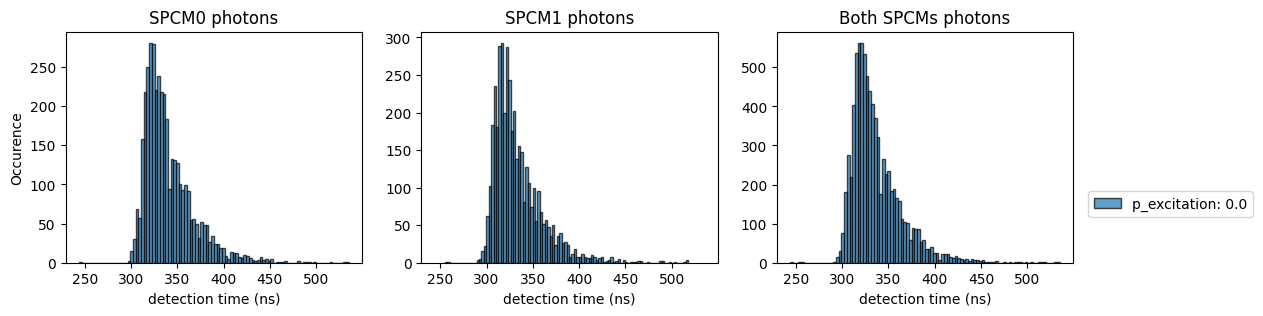

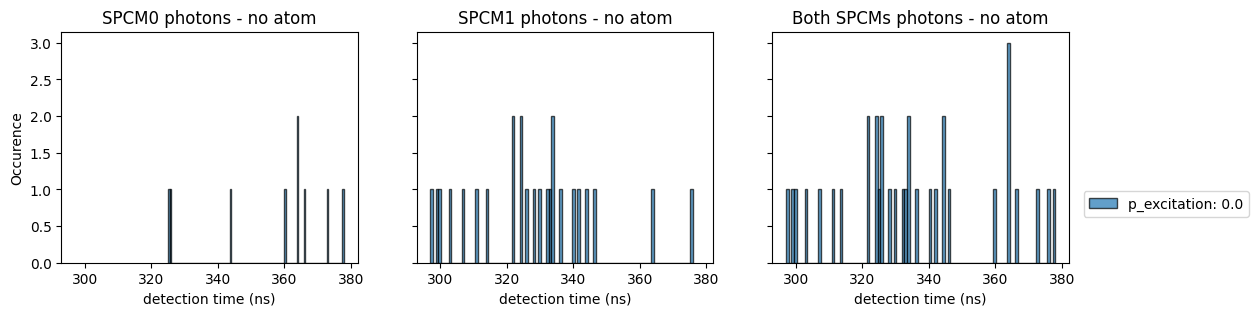

In [22]:
### Print the title of the output
display(HTML(f"""<b style='font-size:18px;'> {date_filters[0]} - RID {rid} - {experiment_function}</b>"""))

for i in range(iterations):
    SPCM0_SinglePhoton_tStamps_i = SPCM0_SinglePhoton_tStamps[1:][n_measurements*n_excitation_cycles*i:(n_measurements*n_excitation_cycles)*(i+1)]
    SPCM1_SinglePhoton_tStamps_i = SPCM1_SinglePhoton_tStamps[1:][n_measurements*n_excitation_cycles*i:(n_measurements*n_excitation_cycles)*(i+1)]
    readout_i = SPCM0_every_exc_RO[1:][n_measurements*n_excitation_cycles*i:(n_measurements*n_excitation_cycles)*(i+1)]
    
    atom_counts_i = 0 # number of atoms retained in each iteration
    for val in readout_i:
        if val > cutoff1:
            atom_counts_i += 1
    
    ### SPCM0
    SPCM0_timestamps_with_atom_i = np.array([p for p,s in zip(SPCM0_SinglePhoton_tStamps_i, readout_i) if s > cutoff1]).flatten()
    SPCM0_timestamps_no_atom_i = np.array([p for p,s in zip(SPCM0_SinglePhoton_tStamps_i, readout_i) if s <= cutoff1]).flatten()
    SPCM0_timestamps_with_atom_i = SPCM0_timestamps_with_atom_i[SPCM0_timestamps_with_atom_i != -1.0] - gate_start_offset_mu*10**-9 ## remove -1 (no click) events
    SPCM0_timestamps_no_atom_i = SPCM0_timestamps_no_atom_i[SPCM0_timestamps_no_atom_i != -1.0] - gate_start_offset_mu*10**-9 ## remove -1 (no click) events
    ## subtracted the offset gate_start_offset_mu*10**-9 to avoid 3-digit time tags.

    
    ### SPCM1
    SPCM1_timestamps_with_atom_i = np.array([p for p,s in zip(SPCM1_SinglePhoton_tStamps_i, readout_i) if s > cutoff1]).flatten()
    SPCM1_timestamps_no_atom_i = np.array([p for p,s in zip(SPCM1_SinglePhoton_tStamps_i, readout_i) if s <= cutoff1]).flatten()
    SPCM1_timestamps_with_atom_i = SPCM1_timestamps_with_atom_i[SPCM1_timestamps_with_atom_i != -1.0] - gate_start_offset_mu*10**-9 ## remove -1 (no click) events
    SPCM1_timestamps_no_atom_i = SPCM1_timestamps_no_atom_i[SPCM1_timestamps_no_atom_i != -1.0] - gate_start_offset_mu*10**-9 ## remove -1 (no click) events

    BothSPCMs_timestamps_with_atom_i = np.concatenate((SPCM0_timestamps_with_atom_i, SPCM1_timestamps_with_atom_i)) 
    BothSPCMs_timestamps_no_atom_i = np.concatenate((SPCM0_timestamps_no_atom_i, SPCM1_timestamps_no_atom_i))

    ### Convert timestamps from s to ns
    SPCM0_timestamps_with_atom_i *= 1e9
    SPCM1_timestamps_with_atom_i *= 1e9
    BothSPCMs_timestamps_with_atom_i *= 1e9

    SPCM0_timestamps_no_atom_i *= 1e9
    SPCM1_timestamps_no_atom_i *= 1e9
    BothSPCMs_timestamps_no_atom_i *= 1e9


    ### Photons arival time histograms (with atom):
    fig, axs = plt.subplots(1, 3, figsize=(13, 3), sharey=False, sharex=True)
    
    axs[0].hist(SPCM0_timestamps_with_atom_i, bins=100, edgecolor='black', alpha=0.7)
    # axs[0].set_xlim(250, 500 )
    axs[0].set_xlabel("detection time (ns)")
    axs[0].set_ylabel("Occurence")
    axs[0].set_title("SPCM0 photons")
    
    axs[1].hist(SPCM1_timestamps_with_atom_i, bins=100, edgecolor='black', alpha=0.7)
    axs[1].set_xlabel("detection time (ns)")
    axs[1].set_title("SPCM1 photons")
    
    axs[2].hist(BothSPCMs_timestamps_with_atom_i, bins=100, edgecolor='black', alpha=0.7, label=f'{scan_variable1_name}: {scan_sequence1[i]}')
    axs[2].set_xlabel("detection time (ns)")
    axs[2].set_title("Both SPCMs photons")
    axs[2].legend(loc=(1.05, 0.2))


    ### Photons arival time histograms (without atom):
    fig, axs = plt.subplots(1, 3, figsize=(13, 3), sharey=True, sharex=True)
    
    axs[0].hist(SPCM0_timestamps_no_atom_i, bins=100, edgecolor='black', alpha=0.7)
    # axs[0].set_xlim(250, 500)
    axs[0].set_xlabel("detection time (ns)")
    axs[0].set_ylabel("Occurence")
    axs[0].set_title("SPCM0 photons - no atom")
    
    axs[1].hist(SPCM1_timestamps_no_atom_i, bins=100, edgecolor='black', alpha=0.7)
    axs[1].set_xlabel("detection time (ns)")
    axs[1].set_title("SPCM1 photons - no atom")
    
    axs[2].hist(BothSPCMs_timestamps_no_atom_i, bins=100, edgecolor='black', alpha=0.7, label=f'{scan_variable1_name}: {scan_sequence1[i]}')
    axs[2].set_xlabel("detection time (ns)")
    axs[2].set_title("Both SPCMs photons - no atom")
    axs[2].legend(loc=(1.05, 0.2))


    print(f'measured number of counts in iteration {i} = {len(BothSPCMs_timestamps_with_atom_i)}')
    print(f'overal efficiency (%) in iteration {i} = {len(BothSPCMs_timestamps_with_atom_i)/atom_counts_i * 100}')


print(f'n_measurements = {n_measurements}')
print(f'n_excitation_cycles = {n_excitation_cycles}')
print(f'excitation pulse width = {t_excitation_pulse/10**-9}','ns')
print(f'SPCM window = {t_photon_collection_time/10**-9}', 'ns')

# plt.hist(BothSPCMs_timestamps_with_atom_i, bins=50, edgecolor='black', alpha=0.7)
# formatter = FuncFormatter(lambda x, _: f'{x * 1e9:.0f}')  # Multiply by 1e9 to convert to ns
# plt.gca().xaxis.set_major_formatter(formatter)

# # Labels and title
# plt.xlabel("detection time (ns)")
# plt.ylabel("Occurence")
# plt.title("Photon wavefunction")
# plt.show()

# plt.hist(BothSPCMs_timestamps_no_atom_i, bins=50, edgecolor='black', alpha=0.7)
# formatter = FuncFormatter(lambda x, _: f'{x * 1e9:.0f}')  # Multiply by 1e9 to convert to ns
# plt.gca().xaxis.set_major_formatter(formatter)
# # Labels and title
# plt.xlabel("detection time (ns)")
# plt.ylabel("Occurence")
# plt.title("Photon wavefunction")
# plt.show()

In [322]:
np.savetxt("BothSPCMs_timestamps_with_atom_RID21962.csv", BothSPCMs_timestamps_with_atom_i, delimiter=",")

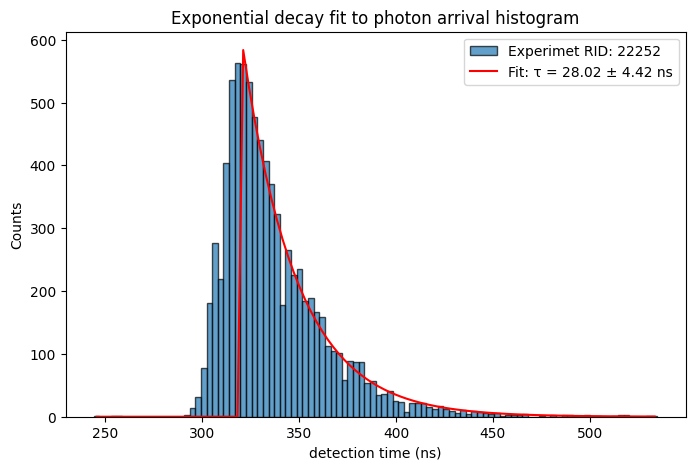

In [281]:
"""   Fitting exponential decay to the histogram  """

data = BothSPCMs_timestamps_with_atom_i
### Create histogram and get bin edges & counts
bin_counts, bin_edges = np.histogram(data, bins=100)  

### Compute bin centers from edges
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

### exponential decay function for fit
def exp_decay(t, t0, N0, tau):
    return N0 * np.exp(-(t - t0) / tau) * (t > t0)  # Step function ensures decay starts at t0

### Initial guesses for fitting parameters
t0_guess = 320  # Estimate for the start of decay
N0_guess = max(bin_counts) 
tau_guess = 26  # Expected atomic lifetime in ns

### Fit the histogram data to the exponential function
params, covariance = curve_fit(exp_decay, bin_centers, bin_counts, p0=[t0_guess, N0_guess, tau_guess])

### Extract fitted parameters and uncertainties
t0_fit, N0_fit, tau_fit = params
t0_err, N0_err, tau_err = np.sqrt(np.diag(covariance))  # Standard errors

### Generate curve using fitted parameters
fit_curve = exp_decay(bin_centers, t0_fit, N0_fit, tau_fit)


plt.figure(figsize=(8, 5))
plt.hist(data, bins=100, edgecolor='black', alpha=0.7, label=f"Experimet RID: {rid}")
plt.plot(bin_centers, fit_curve, 'r-', label=f"Fit: τ = {tau_fit:.2f} ± {tau_err:.2f} ns")

plt.xlabel("detection time (ns)")
plt.ylabel("Counts")
plt.title("Exponential decay fit to photon arrival histogram")
plt.legend()
plt.show()


# Single photon analysis - Readout every excitation cycle (before changing the variable names from counts and counts1)
Analysis for our first search for photons emitted following an excitation pulse, with $g^{(2)}(0)$ calculations for experiments until 2025-01-15.

To use the analysis code, change the dat in date_filters and find the experiment(s) you want to analyse and write in file_indices. If you like the results and you want to keep them, take a screen clip of the results and save in the powerpoint. All the information you need to know about the experiment should be printed at the end. Please add anything is missing.

In [31]:
date_filters = ["2025-01-09"]

from matplotlib import pyplot as plt
import matplotlib as mpl
from matplotlib.lines import Line2D
import csv
import numpy as np
import os,sys
import PIL # for reading tif images
import h5py
import datetime as dt
import time
from scipy.optimize import curve_fit
from skimage.filters import threshold_otsu
from IPython.display import display, HTML ## for large prints

sys.path.append("..\\")
from h5_data_utilities import * # helper functions for dealing with h5 files

def average_over_measurement(measurements, history):
    iteration = len(history) // measurements
    mean_by_iteration = [np.mean(history[j * measurements:(j + 1) * measurements]) for j in range(iteration)]
    return mean_by_iteration


fnames = get_files_by_criteria(date_filters, # only find files from these date directories
                               name_filters=["GeneralVariableScan"], # only find files containing all these strings
                               condition=lambda filename: True, # use this to filter by experiment parameters, like this: lambda filename: np.bool_(h5py.File(filename)['datasets']['set_current_coil_volts_at_finish'])
                               start_dir=results,
                               include_path=True, # if False, only return the name of the file, not the full path
                               print_filenames=True
)


only_show_i_greater_than = -1

print(f"found {len(fnames)} files")
for i,f in enumerate(fnames):
    if i > only_show_i_greater_than:
        try:
            ds = h5py.File(os.path.join(results, f))['datasets']
            scan_str = str_from_h5(ds['scan_variable1_name'])
            if str_from_h5(ds['scan_variable2_name']) != '':
                scan_str += ", " +str_from_h5(ds['scan_variable2_name'])
            print(f"file {i} ({f}) scanned over "+scan_str)
        except:

            print(f"oops... something wrong with {f}")

found 6 files
file 0 (C:\Networking Experiment\artiq codes\artiq-master\results\2025-01-09\11\000021415-GeneralVariableScan.h5) scanned over gate_start_offset_mu
file 1 (C:\Networking Experiment\artiq codes\artiq-master\results\2025-01-09\11\000021416-GeneralVariableScan.h5) scanned over gate_start_offset_mu
file 2 (C:\Networking Experiment\artiq codes\artiq-master\results\2025-01-09\11\000021417-GeneralVariableScan.h5) scanned over gate_start_offset_mu
file 3 (C:\Networking Experiment\artiq codes\artiq-master\results\2025-01-09\11\000021417-GeneralVariableScan_single_photon_experiment_atom_load_scan_over_gate_start_offset_mu.h5) scanned over gate_start_offset_mu
file 4 (C:\Networking Experiment\artiq codes\artiq-master\results\2025-01-09\16\000021418-GeneralVariableScan.h5) scanned over gate_start_offset_mu
file 5 (C:\Networking Experiment\artiq codes\artiq-master\results\2025-01-09\16\000021418-GeneralVariableScan_single_photon_experiment_atom_load_scan_over_gate_start_offset_mu.h5) 

experiment: single_photon_experiment_atom_loading_advance
override: {'dummy_variable':4,'require_atom_loading_to_advance_in_single_photon_exp': True, 'n_excitation_cycles':200, 'set_point_excitation':0.4}
# of iterations:  10


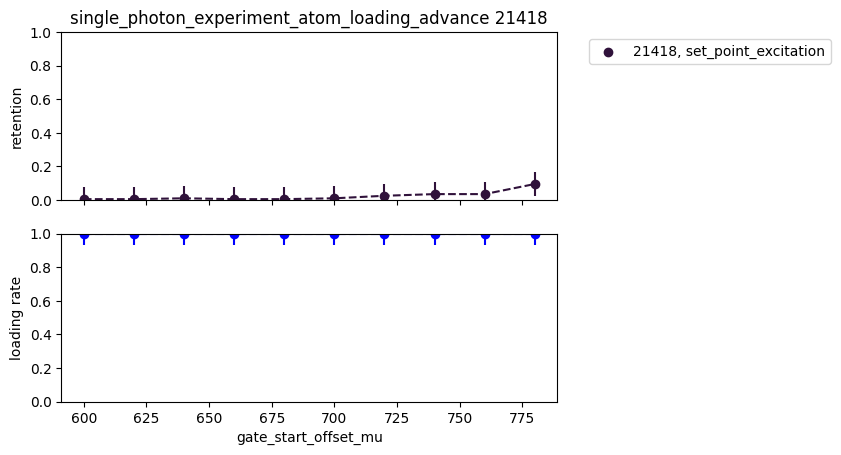

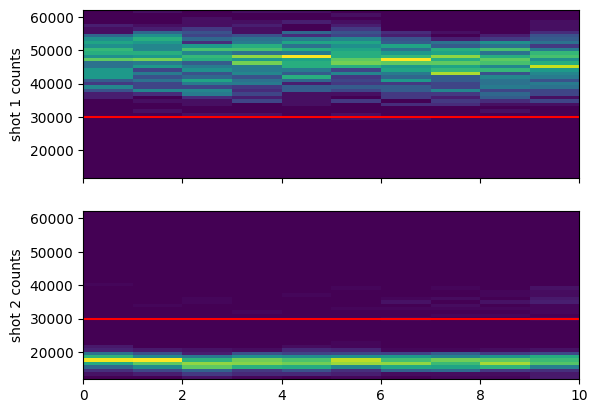

In [35]:
### the file(s) to analyze:
file_indices = {
   4: 'set_point_excitation'
} 


compare = True # compare multiple files in the same retention and loading plots
otsu_threshold = False # compute threshold using Otsu method instead doing it by eye. only work when require atom loading = False
showhist = True
showloading = True
custom_xlabel = True
merge_data = False # if True, the datasets will be combined, and if fit=True, the new merged data will be fit. don't try this in 2D
fit = False

showhist_counts = False 

# for plotting
legend_vars =[]   #legend_vars = ['AY_volts_OP', 'f_microwaves_dds'] # will be included in the plot legend
xform_and_label = {}
loc='best'
ret_cmap = mpl.colormaps['turbo']
ldng_cmap = mpl.colormaps['winter']

# for fitting
fit_dict = {}

if compare:
    if showloading:
        fig_ret,axes = plt.subplots(nrows=2, sharex=True)
        ax_ret, ax_ldng = axes
    else:
        fig_ret,ax_ret = plt.subplots()


first_shot_hists = []
second_shot_hists = []
mean1_by_iteration = []
mean2_by_iteration = []

merged_retention = np.array([])
merged_scan_sequence1 = np.array([])
merged_errs = np.array([])
rid_str = ''


for idx,f_item in enumerate(file_indices.items()):
    f_idx,f_comment = f_item   # idx - f_item = {f_idx: f_comment}
    f = h5py.File(os.path.join(results, fnames[f_idx]))
    rid = f['rid'][()]
    h5_archive_and_datasets_to_locals(f, parent_locals=locals(), quiet=True)
    print("experiment:",experiment_function)
    print("override:",override_ExperimentVariables)

    iterations = len(scan_sequence1) #int(len(photocounts)/n_measurements)
    print("# of iterations: ", iterations)
    
    if otsu_threshold:
        thresh = threshold_otsu(photocounts)
        print("threshold_otsu: ", thresh)
    else:
        cutoff1 = cutoff2 = single_atom_counts_per_s * t_SPCM_first_shot

    
    ### for plotting 
    ### xsteps_xform is a function that can transform scan_sequence1 for plotting. Here it is equal to identity, i.e. no change in scan_sequence1.
    if scan_variable1_name in xform_and_label and custom_xlabel:
        xsteps_xform, xlabel = (xform_and_label[scan_variable1_name]['xsteps_xform'], xform_and_label[scan_variable1_name]['xlabel'])
    else:
        xsteps_xform, xlabel = (lambda x: x, scan_variable1_name)
        

    legend_string = ''
    for a in legend_vars:
        legend_string += f'{a}={locals()[a]}, '
    legend_string = legend_string[:-2]
    f_comment += legend_string

    
    ### get_loading_and_retention
    ### These array have length = iterations
    retention_array, loading_rate_array, n_atoms_loaded_array = get_loading_and_retention(photocounts, photocounts2, n_measurements, iterations, cutoff1, otsu=otsu_threshold)


    ### Necessary to analyze data with 2 scan_sequences
    ### reshaping each array into a 2D array with shape = shape, with order = 'F' (Fortran-style) to sort column by column
    
    ncols = len(scan_sequence2)
    nrows = len(scan_sequence1)
    shape = (len(scan_sequence2),len(scan_sequence1))
    loading_rate_raveled = np.reshape(loading_rate_array,shape,order='F') # rows have constant variable2
    n_atoms_loaded_raveled = np.reshape(n_atoms_loaded_array,shape,order='F') # rows have constant variable2
    retention_raveled = np.reshape(retention_array,shape,order='F') # rows have constant variable2

    
    ### show historam of first_shot and second_shot
    histMin = np.min([photocounts, photocounts2])/t_SPCM_first_shot ## boundary for the histogram plots
    histMax = np.max([photocounts, photocounts2])/t_SPCM_first_shot
    if showhist:
        first_shot_hists.append(
            [np.histogram(photocounts[i*n_measurements:(i+1)*n_measurements]/t_SPCM_first_shot,bins=np.linspace(histMin,histMax,50))[0]
                              for i in range(iterations)])

        second_shot_hists.append(
            [np.histogram(photocounts2[i*n_measurements:(i+1)*n_measurements]/t_SPCM_second_shot,bins=np.linspace(histMin,histMax,50))[0]
                                      for i in range(iterations)])

    
    ### plot a retention curve vs variable 1 for each variable 2 value
    for i, retention, loading, n_loaded, var2 in zip(range(len(scan_sequence2)), retention_raveled, loading_rate_raveled, n_atoms_loaded_raveled, scan_sequence2):
        
        errs = np.array([1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded])
        if not compare:
            if showloading:
                    fig_ret,axes = plt.subplots(nrows=2, sharex=True)
                    ax_ret, ax_ldng = axes
            else:
                fig_ret,ax_ret = plt.subplots()
                
        if not merge_data:
            ax_ret.scatter(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0], label=str(rid)+', '+f_comment, color=ret_cmap(idx/len(file_indices)))
            ax_ret.errorbar(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0], errs[loading > 0], ls='none',color=ret_cmap(idx/len(file_indices)))
            ax_ret.set_ylim((0,1))

            if not ncols > 1 and fit and scan_variable1_name in fit_dict:
                popt, _ = curve_fit(f=fit_dict[scan_variable1_name]['model'], xdata=scan_sequence1, ydata=retention, p0=fit_dict[scan_variable1_name]['p0'], bounds=fit_dict[scan_variable1_name]['bounds'])
                fit_str = "".join([f'{p}={v:.4f}, ' for p,v in zip(fit_dict[scan_variable1_name]['params'], popt)])[:-2]
                print(fit_str)
                hi_res_x = np.linspace(scan_sequence1[0], scan_sequence1[-1], 10*len(scan_sequence1))
                hi_res_x_xform = np.linspace(xsteps_xform(scan_sequence1)[0], xsteps_xform(scan_sequence1)[-1], 10*len(scan_sequence1))
                ax_ret.plot(hi_res_x_xform, fit_dict[scan_variable1_name]['model'](hi_res_x, *popt),linestyle='--',color=ret_cmap(idx/len(file_indices)),label=fit_str)
            else:
                ax_ret.plot(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0],linestyle='--',color=ret_cmap(idx/len(file_indices)))
    
            if not showloading:
                ax_ret.set_xlabel(xlabel)
            ax_ret.set_ylabel("retention")
            #ax_ret.legend(loc=loc)
            ax_ret.legend(bbox_to_anchor=(1.05, 1), loc='upper left')      # This will show the legend outside the plot
            
        else:
            merged_retention = np.concatenate((merged_retention,retention[loading > 0]))
            merged_scan_sequence1 = np.concatenate((merged_scan_sequence1, scan_sequence1[loading > 0]))
            merged_errs = np.concatenate((merged_errs, errs[loading > 0]))
            rid_str += str(rid) + ', '
    
        if showloading:
            ax_ldng.plot(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], linestyle='--',color=ldng_cmap(idx/len(file_indices)))
            ax_ldng.scatter(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], label=rid, color=ldng_cmap(idx/len(file_indices)))
            errs = np.array([1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded])
            ax_ldng.errorbar(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], errs[loading > 0], ls='none', color=ldng_cmap(idx/len(file_indices)))
            ax_ldng.set_ylim((0,1))
            ax_ldng.set_xlabel(xlabel)
            ax_ldng.set_ylabel("loading rate")


if merge_data:
    retention = merged_retention
    scan_sequence1 = merged_scan_sequence1
    errs = merged_errs

    ax_ret.scatter(xsteps_xform(scan_sequence1), retention, color='plum')
    ax_ret.errorbar(xsteps_xform(scan_sequence1), retention, errs, ls='none',color='plum')
    ax_ret.set_ylim((0,1))
    
    if not ncols > 1 and fit and scan_variable1_name in fit_dict:        
        popt, _ = curve_fit(f=fit_dict[scan_variable1_name]['model'], xdata=scan_sequence1, ydata=retention, p0=fit_dict[scan_variable1_name]['p0'], bounds=fit_dict[scan_variable1_name]['bounds'])
        hi_res_x = np.linspace(scan_sequence1[0], scan_sequence1[-1], 10*len(scan_sequence1))
        hi_res_x_xform = np.linspace(xsteps_xform(scan_sequence1)[0], xsteps_xform(scan_sequence1)[-1], 10*len(scan_sequence1))
        fit_str = "".join([f'{p}={v:.4f}, ' for p,v in zip(fit_dict[scan_variable1_name]['params'], popt)])[:-2]
        print(fit_str)
        ax_ret.plot(hi_res_x_xform, fit_dict[scan_variable1_name]['model'](hi_res_x, *popt),linestyle='--',color='violet', label=fit_str)
        ax_ret.legend()
    else:
        ax_ret.plot(xsteps_xform(scan_sequence1), retention,linestyle='--',color='violet')


if not compare or len(file_indices)==1:
    ax_ret.set_title(experiment_function+' '+str(rid))
elif merge_data:
    ax_ret.set_title(experiment_function+' '+ rid_str[:-2])
else:
    ax_ret.set_title(experiment_function)

if showhist:
    fig,axes = plt.subplots(nrows=2,sharex=True)
    ax,ax2 = axes
    cax=ax.imshow(np.array(first_shot_hists[0]).transpose(),origin='lower',extent=[0,iterations,histMin,histMax])
    ax.set_ylabel("shot 1 counts")
    ax.axhline(cutoff1/t_SPCM_first_shot,color='red')
    ax.set_aspect('auto')
    cax2=ax2.imshow(np.array(second_shot_hists[0]).transpose(),origin='lower',extent=[0,iterations,histMin,histMax])
    ax2.set_ylabel("shot 2 counts")
    
    ax2.axhline(cutoff2/t_SPCM_first_shot,color='red')
    ax2.set_aspect('auto')
plt.show()

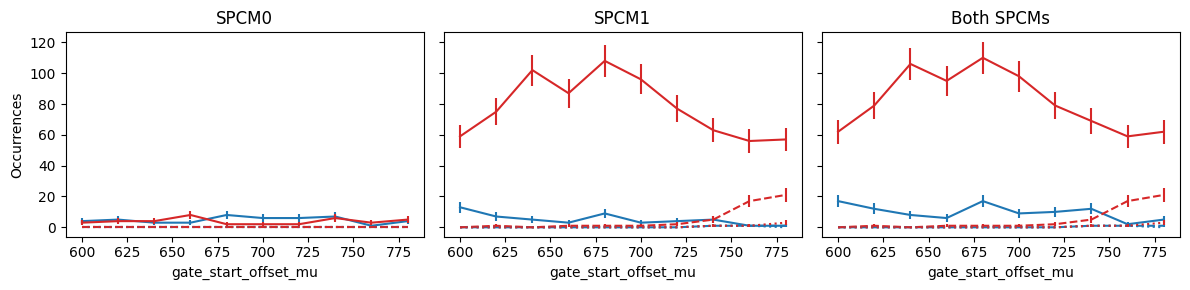

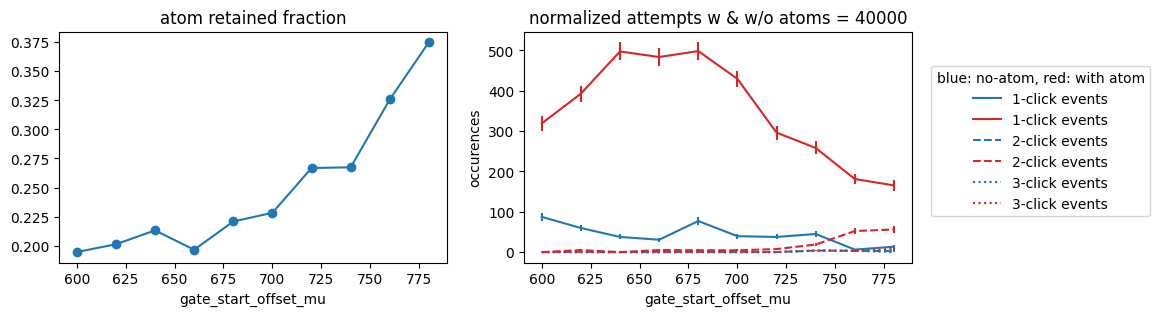

expected number of counts = 2000.0
n_measurements = 200
n_excitation_cycles = 200
excitation pulse width = 50.0 ns
SPCM window = 200.0 ns
excitation power set point = 0.4
SPCM gate start offset = 750


In [36]:
max_counts = max(max(excitation_counts),max(excitation_counts1))+1
bins = list(np.array(list(range(max_counts+1))))  #[0,1,...,max_counts+1]

titles = [f"{scan_variable1_name}: {val}" for val in scan_sequence1]
use_titles = True

binned_data_with_atom = []
binned_data_no_atom = []

atom_counts_all_iterations = np.zeros(iterations)
atom_fraction_all_iterations = np.zeros(iterations)

SPCM0_binned_with_atom_all_iterations = []
SPCM0_binned_no_atom_all_iterations = []

SPCM1_binned_with_atom_all_iterations = []
SPCM1_binned_no_atom_all_iterations = []

g2_0_with_atom = np.zeros(iterations)
g2_0_no_atom = np.zeros(iterations)

for i in range(iterations):

    ### photons are counted from SPCMs 0 and 1 for the excitation phase
    SPCM0_counts_i = excitation_counts[1:][n_measurements*n_excitation_cycles*i:(n_measurements*n_excitation_cycles)*(i+1)]
    SPCM1_counts_i = excitation_counts1[1:][n_measurements*n_excitation_cycles*i:(n_measurements*n_excitation_cycles)*(i+1)]
    readout_i = readout_counts[1:][n_measurements*n_excitation_cycles*i:(n_measurements*n_excitation_cycles)*(i+1)]
    
    ### SPCM0
    SPCM0_counts_with_atom_i = np.array([p for p,s in zip(SPCM0_counts_i, readout_i) if s > cutoff1]).flatten()
    SPCM0_counts_no_atom_i = np.array([p for p,s in zip(SPCM0_counts_i, readout_i) if s <= cutoff1]).flatten()
    
    ### SPCM1
    SPCM1_counts_with_atom_i = np.array([p for p,s in zip(SPCM1_counts_i, readout_i) if s > cutoff1]).flatten()
    SPCM1_counts_no_atom_i = np.array([p for p,s in zip(SPCM1_counts_i, readout_i) if s <= cutoff1]).flatten()

    ### Calculate g2(0) for the current iteration
    ### with atom:
    n_coincidence_with_atom_i = np.sum((SPCM0_counts_with_atom_i >= 1) & (SPCM1_counts_with_atom_i >= 1))
    n_SPCM0_counts_with_atom_i = np.sum(SPCM0_counts_with_atom_i >= 1)
    n_SPCM1_counts_with_atom_i = np.sum(SPCM1_counts_with_atom_i >= 1)
    n_trial = len(SPCM0_counts_with_atom_i) 

    if n_SPCM0_counts_with_atom_i > 0 and n_SPCM1_counts_with_atom_i > 0:
        g2_0 = (n_coincidence_with_atom_i / 
                  (n_SPCM0_counts_with_atom_i * n_SPCM1_counts_with_atom_i)) * n_trial
    else:
        g2_0 = np.nan 
    g2_0_with_atom[i] = g2_0

    ### without atom:
    n_coincidence_no_atom_i = np.sum((SPCM0_counts_no_atom_i >= 1) & (SPCM1_counts_no_atom_i >= 1))
    n_SPCM0_counts_no_atom_i = np.sum(SPCM0_counts_no_atom_i >= 1)
    n_SPCM1_counts_no_atom_i = np.sum(SPCM1_counts_no_atom_i >= 1)
    n_trial = len(SPCM0_counts_no_atom_i) 

    if n_SPCM0_counts_no_atom_i > 0 and n_SPCM1_counts_no_atom_i > 0:
        g2_0 = (n_coincidence_no_atom_i / 
                  (n_SPCM0_counts_no_atom_i * n_SPCM1_counts_no_atom_i)) * n_trial
    else:
        g2_0 = np.nan
    g2_0_no_atom[i] = g2_0
    

    ### for normalization
    atom_counts_i = 0 # number of atoms retained in each iteration
    for val in readout_i:
        if val > cutoff1:
            atom_counts_i += 1
    atom_counts_all_iterations[i] = atom_counts_i
    if len(readout_i) > 0:
        atom_fraction_all_iterations[i] = atom_counts_i / len(readout_i)

    ### Binning for counting photon clicks
    SPCM0_binned_with_atom_i = np.histogram(SPCM0_counts_with_atom_i, bins=bins)[0]
    SPCM0_binned_with_atom_all_iterations.append(SPCM0_binned_with_atom_i)

    SPCM0_binned_no_atom_i = np.histogram(SPCM0_counts_no_atom_i, bins=bins)[0]
    SPCM0_binned_no_atom_all_iterations.append(SPCM0_binned_no_atom_i)

    SPCM1_binned_with_atom_i = np.histogram(SPCM1_counts_with_atom_i, bins=bins)[0]
    SPCM1_binned_with_atom_all_iterations.append(SPCM1_binned_with_atom_i)

    SPCM1_binned_no_atom_i = np.histogram(SPCM1_counts_no_atom_i, bins=bins)[0]
    SPCM1_binned_no_atom_all_iterations.append(SPCM1_binned_no_atom_i)


### transposing the array for plotting and removing 0 counts:
SPCM0_binned_with_atom_all_iterations_trans = np.array(SPCM0_binned_with_atom_all_iterations).transpose()[1:]
SPCM0_binned_no_atom_all_iterations_trans = np.array(SPCM0_binned_no_atom_all_iterations).transpose()[1:]

SPCM1_binned_with_atom_all_iterations_trans = np.array(SPCM1_binned_with_atom_all_iterations).transpose()[1:]
SPCM1_binned_no_atom_all_iterations_trans = np.array(SPCM1_binned_no_atom_all_iterations).transpose()[1:]

SPCM1and2_binned_with_atom_all_iterations_trans = SPCM0_binned_with_atom_all_iterations_trans + SPCM1_binned_with_atom_all_iterations_trans
SPCM1and2_binned_no_atom_all_iterations_trans = SPCM0_binned_no_atom_all_iterations_trans + SPCM1_binned_no_atom_all_iterations_trans

### Print the title of the output
display(HTML(f"""<b style='font-size:18px;'> {date_filters[0]} - RID {rid} - {experiment_function}</b>"""))


### Un-normalized plots
fig, axs = plt.subplots(1, 3, figsize=(12, 3), sharey=True)
linestyles = ['solid','dashed','dotted','dashdot']

### First plot (SPCM0)
atom_data = SPCM0_binned_with_atom_all_iterations_trans
no_atom_data = SPCM0_binned_no_atom_all_iterations_trans
for i in range(max(bins)-1):
    axs[0].plot(scan_sequence1, no_atom_data[i], label=f'{i+1}-click events', ls=linestyles[i], color='tab:blue')
    axs[0].plot(scan_sequence1, atom_data[i], label=f'{i+1}-click events', ls=linestyles[i], color='tab:red')
    axs[0].errorbar(scan_sequence1, no_atom_data[i], yerr=[np.sqrt(x) if x > 0 else np.inf for x in no_atom_data[i]], ls='none', color='tab:blue')
    axs[0].errorbar(scan_sequence1, atom_data[i], yerr=[np.sqrt(x) if x > 0 else np.inf for x in atom_data[i]], ls='none', color='tab:red')

axs[0].set_title('SPCM0')
axs[0].set_ylabel('Occurrences')
axs[0].set_xlabel(scan_variable1_name)


### Second plot (SPCM1)
atom_data = SPCM1_binned_with_atom_all_iterations_trans
no_atom_data = SPCM1_binned_no_atom_all_iterations_trans
for i in range(max(bins)-1):
    axs[1].plot(scan_sequence1, no_atom_data[i], label=f'{i+1}-click events', ls=linestyles[i], color='tab:blue')
    axs[1].plot(scan_sequence1, atom_data[i], label=f'{i+1}-click events', ls=linestyles[i], color='tab:red')
    axs[1].errorbar(scan_sequence1, no_atom_data[i], yerr=[np.sqrt(x) if x > 0 else np.inf for x in no_atom_data[i]], ls='none', color='tab:blue')
    axs[1].errorbar(scan_sequence1, atom_data[i], yerr=[np.sqrt(x) if x > 0 else np.inf for x in atom_data[i]], ls='none', color='tab:red')

axs[1].set_title('SPCM1')
axs[1].set_xlabel(scan_variable1_name)


### 3rd plot (Both SPCMs)
atom_data = SPCM1and2_binned_with_atom_all_iterations_trans
no_atom_data = SPCM1and2_binned_no_atom_all_iterations_trans
for i in range(max(bins)-1):
    axs[2].plot(scan_sequence1, no_atom_data[i], label=f'{i+1}-click events', ls=linestyles[i], color='tab:blue')
    axs[2].plot(scan_sequence1, atom_data[i], label=f'{i+1}-click events', ls=linestyles[i], color='tab:red')
    axs[2].errorbar(scan_sequence1, no_atom_data[i], yerr=[np.sqrt(x) if x > 0 else np.inf for x in no_atom_data[i]], ls='none', color='tab:blue')
    axs[2].errorbar(scan_sequence1, atom_data[i], yerr=[np.sqrt(x) if x > 0 else np.inf for x in atom_data[i]], ls='none', color='tab:red')

axs[2].set_title('Both SPCMs')
axs[2].set_xlabel(scan_variable1_name)
# axs[2].legend(loc=(1.05, 0.2), title='blue: no-atom, red: with atom')

plt.tight_layout()
plt.show()


### atom retained fraction:
fig, axs = plt.subplots(1, 2, figsize=(11, 3))
axs[0].plot(scan_sequence1,atom_fraction_all_iterations, marker='o')
axs[0].set_xlabel(scan_variable1_name)
axs[0].set_title("atom retained fraction")


### normalized both SPCMs:
atom_data = SPCM1and2_binned_with_atom_all_iterations_trans
no_atom_data = SPCM1and2_binned_no_atom_all_iterations_trans

no_atom_data_norm = no_atom_data/atom_fraction_all_iterations
atom_data_norm = atom_data/atom_fraction_all_iterations


for i in range(max(bins)-1):
    axs[1].plot(scan_sequence1, no_atom_data_norm[i],label=f'{i+1}-click events',ls=linestyles[i],color='tab:blue')
    axs[1].plot(scan_sequence1, atom_data_norm[i],label=f'{i+1}-click events',ls=linestyles[i],color='tab:red')
    axs[1].errorbar(scan_sequence1, no_atom_data_norm[i], yerr=[np.sqrt(x) if x > 0 else np.inf for x in no_atom_data_norm[i]], ls='none',color='tab:blue')
    axs[1].errorbar(scan_sequence1, atom_data_norm[i], yerr=[np.sqrt(x) if x > 0 else np.inf for x in atom_data_norm[i]], ls='none',color='tab:red')
axs[1].legend(loc=(1.05,0.2), title = 'blue: no-atom, red: with atom')
axs[1].set_title(f'normalized attempts w & w/o atoms = {n_excitation_cycles * n_measurements}')
axs[1].set_ylabel('occurences')
axs[1].set_xlabel(scan_variable1_name)
plt.show()


# ### Plot g2
# plt.figure(figsize=(5, 3))
# plt.plot(scan_sequence1, g2_0_with_atom, label='g2(0) with atom', marker='o', color='tab:red')
# plt.plot(scan_sequence1, g2_0_no_atom, label='g2(0) no atom', marker='s', color='tab:blue')
# plt.errorbar(scan_sequence1, g2_0_with_atom, yerr=[np.sqrt(x) if x > 0 else np.inf for x in g2_0_with_atom], ls='none',color='tab:red')
# plt.errorbar(scan_sequence1, g2_0_no_atom, yerr=[np.sqrt(x) if x > 0 else np.inf for x in g2_0_no_atom], ls='none',color='tab:blue')
# plt.legend(loc=(1.05,0.5))
# plt.xlabel(scan_variable1_name)
# plt.ylabel('g2(0)')
# plt.show()


Col_Eff = 0.05 # overal expected/theoretical collection and detection efficiency 
print(f'expected number of counts = {n_excitation_cycles * n_measurements * Col_Eff}')
print(f'n_measurements = {n_measurements}')
print(f'n_excitation_cycles = {n_excitation_cycles}')
print(f'excitation pulse width = {t_excitation_pulse/10**-9}','ns')
print(f'SPCM window = {t_photon_collection_time/10**-9}', 'ns')
print(f'excitation power set point = {set_point_excitation}')
print(f'SPCM gate start offset = {gate_start_offset_mu}')
